# Parameter Recovery

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/hanhou/Dynamic-Foraging/master?filepath=%2FModelRecovery%2FForaging_model_recovery.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2

# Uncomment next line to enable interactive plots!
# %matplotlib notebook

import numpy as np
from run_model_recovery import *
import multiprocessing as mp
import matplotlib.pyplot as plt

n_worker = int(mp.cpu_count()/2)
pool = mp.Pool(processes = n_worker)
    
# Parameter settings
n_trials = 1000

First, what this notebook is all about ([Wilson and Collins 2019](https://elifesciences.org/articles/49547)) and a very ugly blueprint.<br>
See the previous notebook (blue part) [here](https://github.com/hanhou/Dynamic-Foraging/blob/master/Models/Foraging_Testbed.ipynb).

<img src="Blueprint.png" />

## 1. Paremeter Recovery (Fig. 4  in Wilson and Collins 2019)

As a first step, I will use the simplest model, `LossCounting`, to test different optimization methods. I'll try to open the black box to see how they work. Hope this step could lay a solid foundation for further fittings.

Methods I will test:
- Global optimizers with bounds (`DE`): one initialization, use its own parallel method
- Local optimizers with bounds (`L-BFGS-B`, `SLSQP`, `TNC`, `trust-constr`): random initializations in parallel<br>


### 1.1 LossCounting (the simplest prototype)

If we fix threshold_std = 0, perfect. Note that the para_bounds are still [0,50],[0,10]

Parameter Recovery, LossCounting: 100%|████████████████████████████████████████████████| 30/30 [03:50<00:00,  7.70s/it]
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


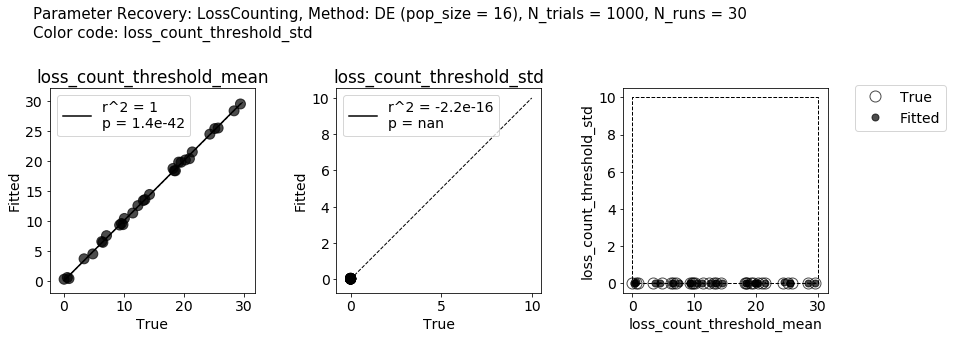

In [22]:
n_trials = 1000

forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[30,10]]

# Para recovery
true_paras = generate_true_paras([[0,0],[30,0]], n_models = 30, method = 'random_uniform')

fit_para_recovery(forager = forager, 
                  para_names = para_names, para_bounds = para_bounds, 
                  true_paras = true_paras, n_trials = n_trials, 
                  fit_method = 'DE', pool = pool);    


If we allow `loss_count_threshold_std` > 0, we will have huge discrepancies between fitted and true parameters when `loss_count_threshold_std` is large.

Parameter Recovery, LossCounting: 100%|████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.46s/it]


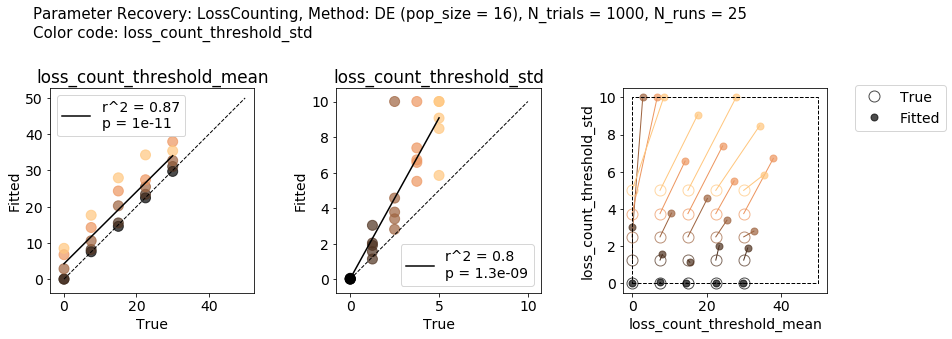

In [19]:
n_trials = 1000

forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[50,10]]

# Para recovery
true_paras = generate_true_paras([[0,0],[30,5]], n_models = [5,5], method = 'linspace')

fit_para_recovery(forager = forager, 
                  para_names = para_names, para_bounds = para_bounds, 
                  true_paras = true_paras, n_trials = n_trials, 
                  fit_method = 'DE', pool = pool);    

### Likelihood landscape and DE history (Fig.3a in Wilson and Collins 2019)

Likelihood landscape plots show that the huge discrepancy is not due to the fitting *per se*, but due to a systematic bias introduced by the inherent correlation between `loss_count_threshold_mean` and `loss_count_threshold_std`. The ***ridge*** in the landscape indicates a trade-off between the two parameters (see Wilson and Collins 2019). **Importantly, the true value is not even on the ridge!!**

Fitting using DE (pop_size = 16), pool = True...
  True para: [10  4]
Fitted para: [19.993  7.962]


LL_surface pair #0: 100%|███████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 107.69it/s]


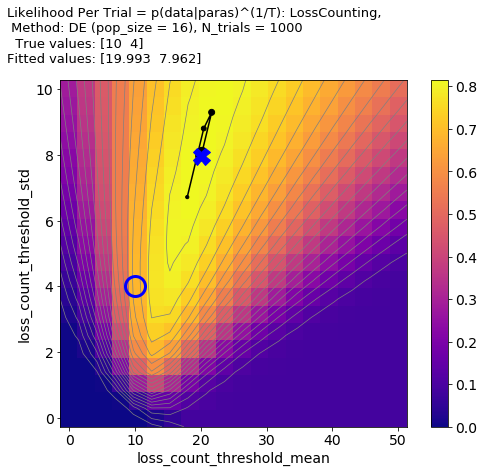

In [8]:
n_trials = 1000
forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[50,10]]
true_para = [10,4]

# LL_surface
compute_LL_surface(forager, para_names, para_bounds,
                   true_para = true_para, n_trials = n_trials,
                   fit_method = 'DE', pool = pool);


No such bias when true_std = 0, because the ***ridge*** now becomes a ***peak***.
(also, note how fast `DE` converges! Only one iteration!)

Adjusted true para on grid: [10.526  0.   ]
Fitting using DE (pop_size = 16), pool = True...
Fitted para: [10.673  0.028]


LL_surface pair #0: 100%|███████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 105.71it/s]


<IPython.core.display.Javascript object>


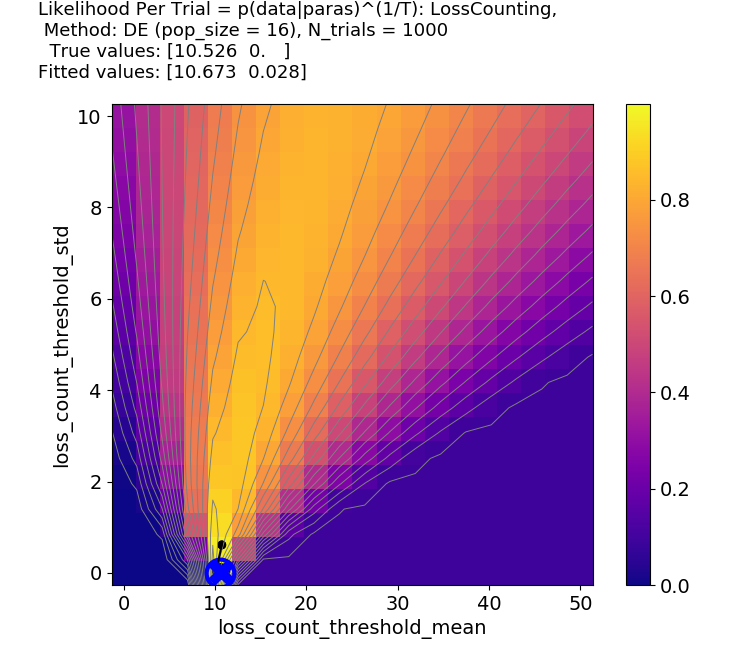

In [58]:
n_trials = 1000
forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[50,10]]
true_para = [10,0]

# LL_surface
compute_LL_surface(forager, para_names, para_bounds,
                   true_para = true_para, n_trials = n_trials,
                   fit_method = 'DE', pool = pool);

BTW, here is a cool [demo](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/) of [`differential evolution`](https://www1.icsi.berkeley.edu/~storn/code.html). This problem will drive the following local optimizers CRAZY...
<img src="https://pablormier.github.io/assets/img/de/ackley.gif" />

### Compare global optimizer with local optimizer (with `n_x0s` different initializations)


==> Speed: DE > SLSQP > L-BFGS-B >> TNC >>> trust-constr

#### DE

Parameter Recovery, LossCounting: 100%|████████████████████████████████████████████████| 25/25 [02:42<00:00,  6.51s/it]


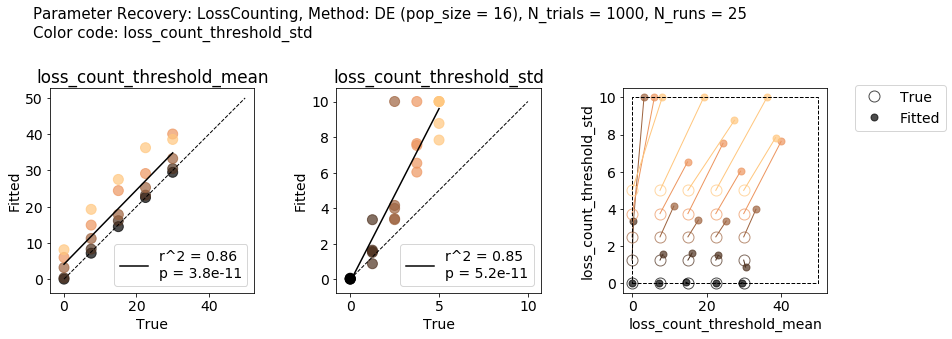

In [20]:
n_trials = 1000

forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[50,10]]

# Para recovery
true_paras = generate_true_paras([[0,0],[30,5]], n_models = [5,5], method = 'linspace')

fit_para_recovery(forager = forager, 
                  para_names = para_names, para_bounds = para_bounds, 
                  true_paras = true_paras, n_trials = n_trials, 
                  fit_method = 'DE', pool = pool);    

#### L-BFGS-B

`n_x0s` = 1: Lots of local minima!!

Parameter Recovery, LossCounting: 100%|████████████████████████████████████████████████| 25/25 [01:25<00:00,  3.43s/it]


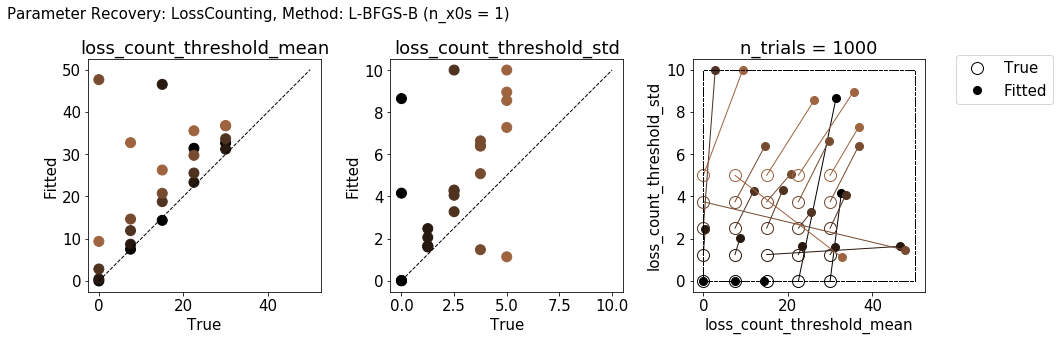

In [2]:
n_trials = 1000

forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[50,10]]

# Para recovery
true_paras = generate_true_paras([[0,0],[30,5]], n_models = [5,5], method = 'linspace')
fit_para_recovery(forager = forager, 
                  para_names = para_names, para_bounds = para_bounds, 
                  true_paras = true_paras, n_trials = n_trials, 
                  fit_method = 'L-BFGS-B', n_x0s = 1, pool = pool);    

`n_x0s` = 8: no local optima issue! (in parallel)

Parameter Recovery, LossCounting: 100%|████████████████████████████████████████████████| 25/25 [02:53<00:00,  6.95s/it]


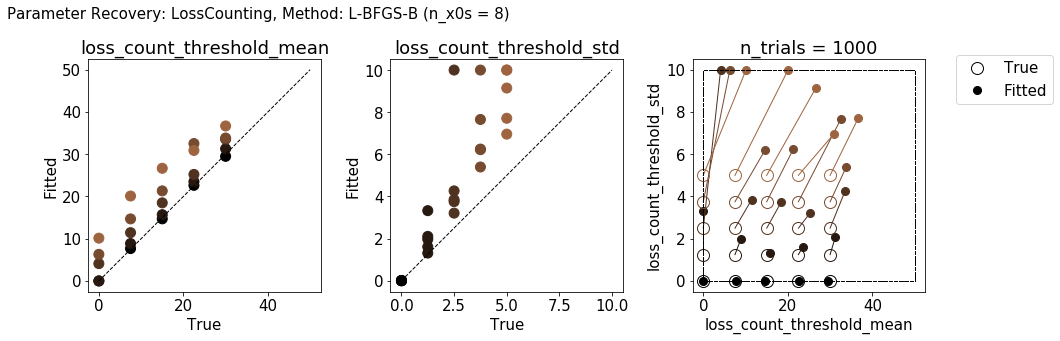

In [3]:
n_trials = 1000

forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[50,10]]

# Para recovery
true_paras = generate_true_paras([[0,0],[30,5]], n_models = [5,5], method = 'linspace')
fit_para_recovery(forager = forager, 
                  para_names = para_names, para_bounds = para_bounds, 
                  true_paras = true_paras, n_trials = n_trials, 
                  fit_method = 'L-BFGS-B', n_x0s = 8, pool = pool);    

`n_x0s` = 16: very robust, but slow. Not necessary.

Parameter Recovery, LossCounting: 100%|████████████████████████████████████████████████| 25/25 [05:20<00:00, 12.82s/it]


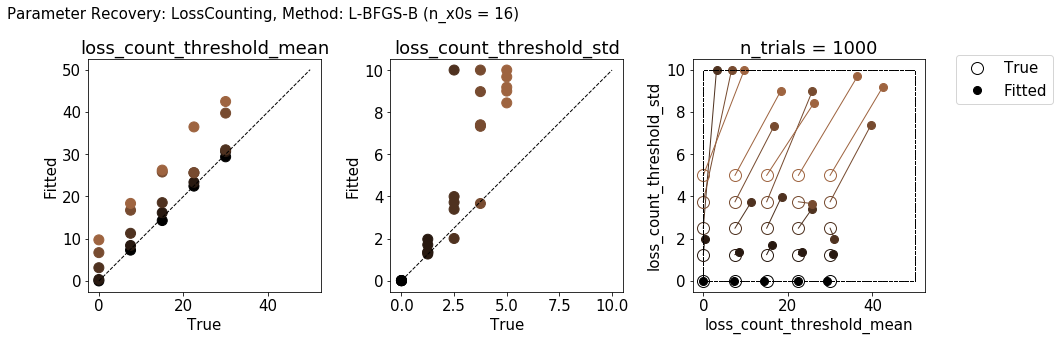

In [4]:
n_trials = 1000

forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[50,10]]

# Para recovery
true_paras = generate_true_paras([[0,0],[30,5]], n_models = [5,5], method = 'linspace')
fit_para_recovery(forager = forager, 
                  para_names = para_names, para_bounds = para_bounds, 
                  true_paras = true_paras, n_trials = n_trials, 
                  fit_method = 'L-BFGS-B', n_x0s = 16, pool = pool);    

#### SLSQP (seems to be faster than L-BFGS-B?)

Parameter Recovery, LossCounting: 100%|████████████████████████████████████████████████| 25/25 [02:38<00:00,  6.32s/it]


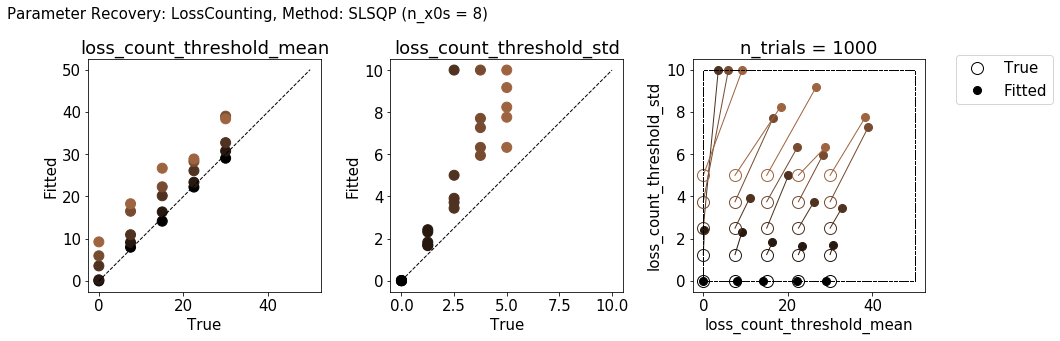

In [5]:
n_trials = 1000

forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[50,10]]

# Para recovery
true_paras = generate_true_paras([[0,0],[30,5]], n_models = [5,5], method = 'linspace')
fit_para_recovery(forager = forager, 
                  para_names = para_names, para_bounds = para_bounds, 
                  true_paras = true_paras, n_trials = n_trials, 
                  fit_method = 'SLSQP', n_x0s = 8, pool = pool);    

#### ~TNC (too slow!!!)~

Parameter Recovery, LossCounting: 100%|████████████████████████████████████████████████| 25/25 [11:09<00:00, 26.80s/it]


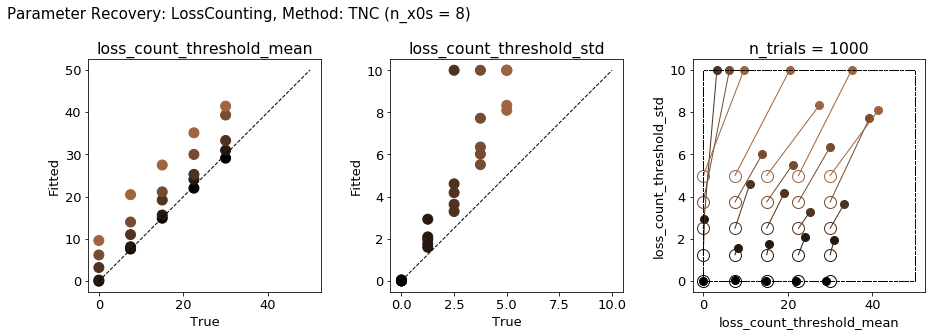

In [3]:
n_trials = 1000

forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[50,10]]

# Para recovery
true_paras = generate_true_paras([[0,0],[30,5]], n_models = [5,5], method = 'linspace')
fit_para_recovery(forager = forager, 
                  para_names = para_names, para_bounds = para_bounds, 
                  true_paras = true_paras, n_trials = n_trials, 
                  fit_method = 'TNC', n_x0s = 8, pool = pool);    

#### ~trust-constr (toooooooo slow)~

Parameter Recovery, LossCounting: 100%|████████████████████████████████████████████████| 25/25 [09:26<00:00, 22.64s/it]


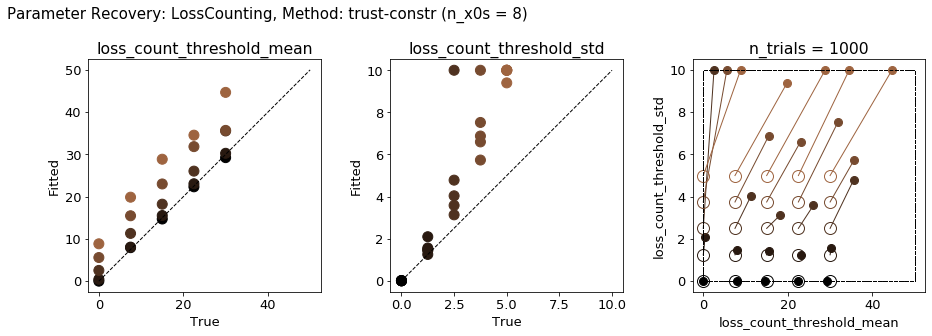

In [4]:
n_trials = 1000

forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[50,10]]

# Para recovery
true_paras = generate_true_paras([[0,0],[30,5]], n_models = [5,5], method = 'linspace')
fit_para_recovery(forager = forager, 
                  para_names = para_names, para_bounds = para_bounds, 
                  true_paras = true_paras, n_trials = n_trials, 
                  fit_method = 'trust-constr', n_x0s = 8, pool = pool);    

### Multiple initialization on the likelihood landscape

Let's plot multiple histories of local optimizers (should use `pool = ''` because I have difficulty storing the intermediate results in callbacks during parallelizing local optimizers). <br>
**Note the dots on the southeastern plateau. They failed to converge due to bad initializations. Also note how the traces wander on the ridge...**

Adjusted true para on grid: [10.526  4.211]
Fitting using L-BFGS-B (n_x0s = 8), pool = False...
Fitted para: [22.775 10.   ]


LL_surface pair #0: 100%|███████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 102.18it/s]


<IPython.core.display.Javascript object>


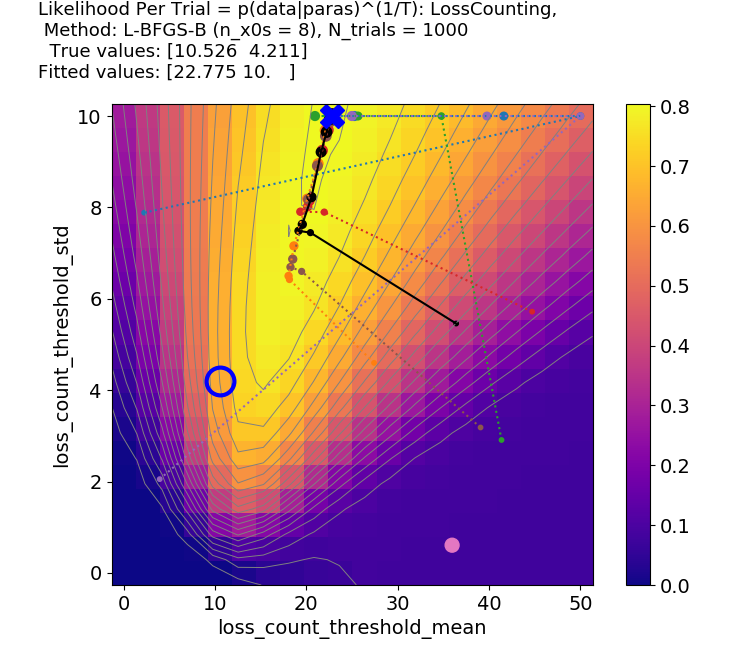

In [55]:
n_trials = 1000
forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[50,10]]

true_para = [10,4]

# LL_surface
compute_LL_surface(forager, para_names, para_bounds,
                   true_para = true_para, n_trials = n_trials,
                   fit_method = 'L-BFGS-B', n_x0s = 8, pool = '');


Adjusted true para on grid: [10.526  0.   ]
Fitting using L-BFGS-B (n_x0s = 8), pool = False...
Fitted para: [10.413  0.   ]


LL_surface pair #0: 100%|███████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 104.80it/s]


<IPython.core.display.Javascript object>


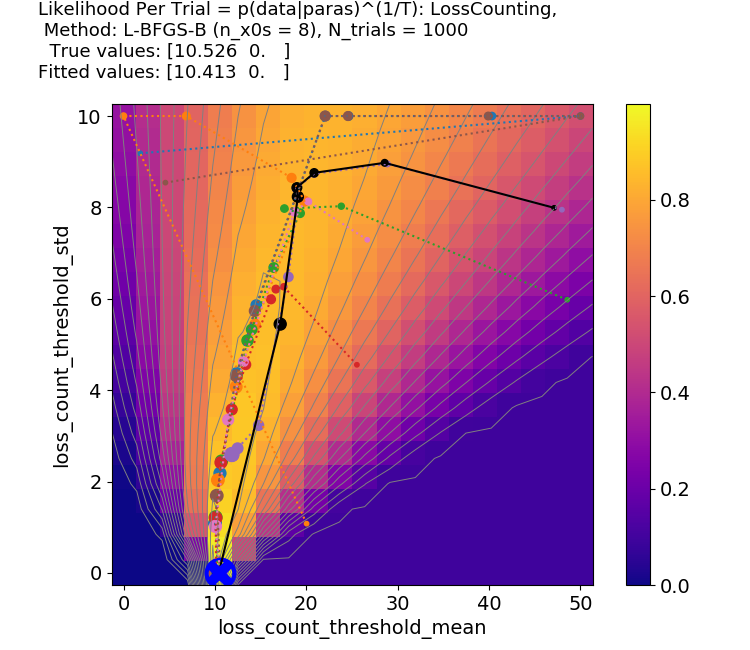

In [54]:
n_trials = 1000
forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[50,10]]
true_para = [10,0]

# LL_surface
compute_LL_surface(forager, para_names, para_bounds,
                   true_para = true_para, n_trials = n_trials,
                   fit_method = 'L-BFGS-B', n_x0s = 8, pool = '');


`SLSQP` seems to be faster than `L-BFGS-B` (and also it has a nicer name). Let's see how it converges.<br>
==> More "explorative" than L-B? The traces are crazy; plus, more initializations failed to converge (zigzags even on the x-axis)

Adjusted true para on grid: [10.526  0.   ]
Fitting using SLSQP (n_x0s = 8), pool = False...
Fitted para: [10.32  0.  ]


LL_surface pair #0: 100%|███████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 104.83it/s]


<IPython.core.display.Javascript object>


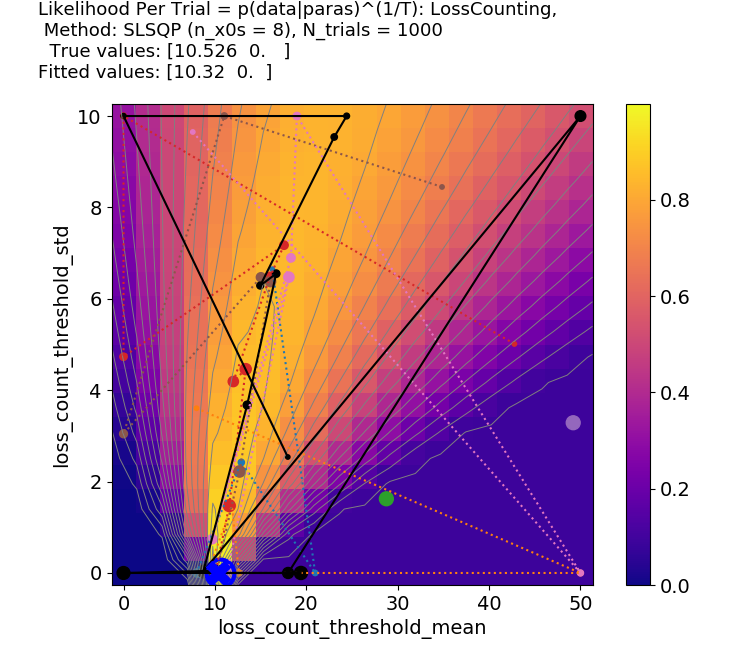

In [53]:
n_trials = 1000
forager = 'LossCounting'
para_names = ['loss_count_threshold_mean','loss_count_threshold_std']
para_bounds = [[0,0],[50,10]]
true_para = [10,0]

# LL_surface
compute_LL_surface(forager, para_names, para_bounds, 
                   true_para = true_para, n_trials = n_trials,
                   fit_method = 'SLSQP', n_x0s = 8, pool = '');


## Intermediate Summary (1)

1. `DE` is the first choice
2. `L-BFGS-B` is the second choice, with the number of initializations at least 8.
3. `SLSQP` is a potential choice. Maybe exploration is desirable in some cases. Who knows.
4. Case-by-case fine tuning of algorithm parameters (mutation, etc.) may be beneficial
5. Plotting likelihood landscape by brutal force is quite informative. It can give us confidence intervals. We can follow this:<br>
    (1) Find maximal likelihood using `DE` etc.<br>
    (2) Plot likelihood landscape for any 2 (or 3) parameters of interest around the global optimal, while keeping other parameters fixed
6. Pay attention to correlations between parameters (indicated by ***ridges*** in the likelihood landscape). This will definitely limit the accuracy of parameter recovery, but hopefully it won't change the results of model recovery (since the maximal likelihood is even larger than the likelihood of the true value in the above case)<br>

I will redo these things occasionally for other models. 

### 1.2 LNP_softmax (based on Corrado 2005)

#### 1.2.1 $\tau_1$ and $\sigma$ (Sugrue2004 but with softmax) <a id='Sugrue'></a>

Figure 4 of Wilson and Collins 2019 (use the same format: alpha = 1/tau1, beta = 1/softmax_temperature)

Very similar results! (ignore the right panel)

Parameter Recovery, NLP_softmax: 100%|███████████████████████████████████████████████| 100/100 [05:49<00:00,  3.49s/it]


<IPython.core.display.Javascript object>


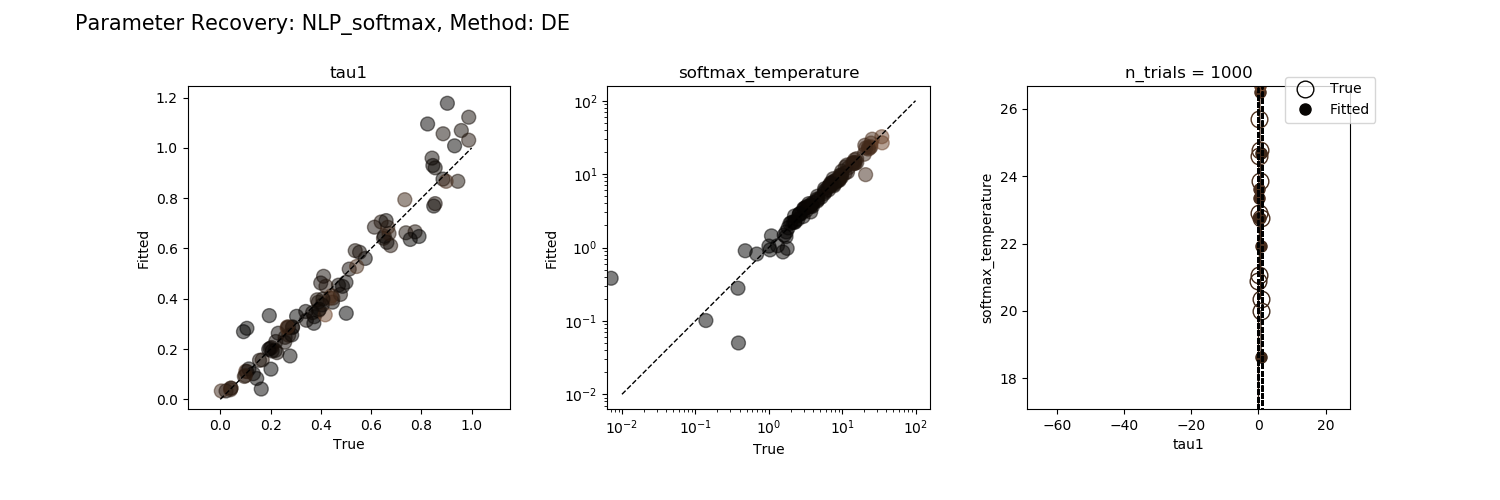

In [4]:
Nothing. Don't update this!!!


OK, use my own way

Parameter Recovery, LNP_softmax: 100%|█████████████████████████████████████████████████| 50/50 [02:54<00:00,  3.49s/it]


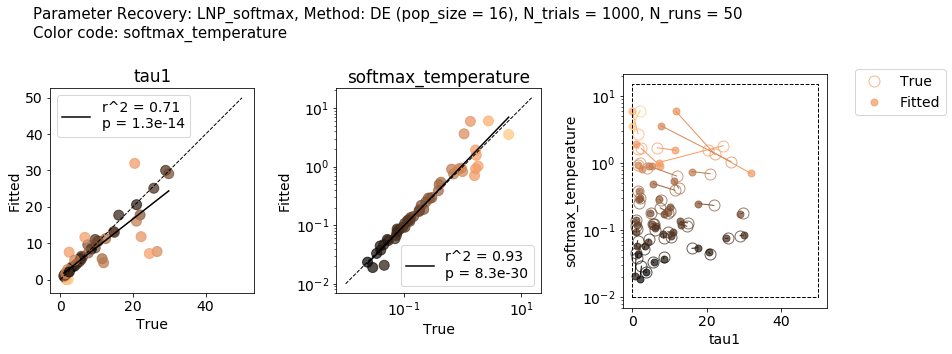

In [16]:
n_trials = 1000

forager = 'LNP_softmax'
para_names = ['tau1','softmax_temperature']
para_scales = ['linear','log']
para_bounds = [[1e-3,1e-2],[50,15]]

n_models = 50
true_paras = np.vstack((10**np.random.uniform(0, np.log10(30), size = n_models),
                        1/np.random.exponential(10, size = n_models))) # Inspired by Wilson 2019. I found beta ~ Exp(10) would be better

true_paras, fitted_para = fit_para_recovery(forager, 
              para_names, para_bounds, true_paras, n_trials = n_trials, 
              para_scales = para_scales,
              fit_method = 'DE', pool = pool);    


#### LL surface

When `softmax_temperature` is small, LL is convex, cool.

Adjusted true para on grid: [21.053  0.101]
Fitting using L-BFGS-B (n_x0s = 8), pool = False...
Fitted para: [19.391  0.105]


LL_surface pair #0: 100%|███████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 228.92it/s]


<IPython.core.display.Javascript object>


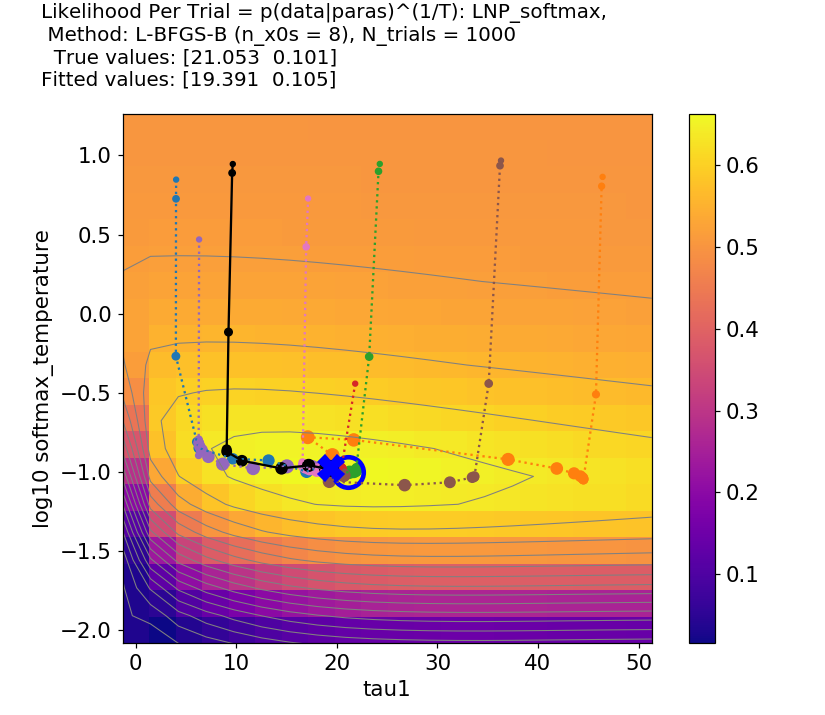

In [11]:
n_trials = 1000

forager = 'LNP_softmax'
para_names = ['tau1','softmax_temperature']
para_scales = ['linear','log']
para_bounds = [[1e-3,1e-2],[50,15]]

compute_LL_surface(forager, para_names, para_bounds, para_scales = para_scales,
                   true_para = [20, .1], n_trials = n_trials, 
                   fit_method = 'L-BFGS-B', n_x0s = 8, pool = '')


Adjusted true para on grid: [21.053  0.101]
Fitting using DE (pop_size = 16), pool = True...
Fitted para: [22.619  0.101]


LL_surface pair #0: 100%|███████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 251.45it/s]


<IPython.core.display.Javascript object>


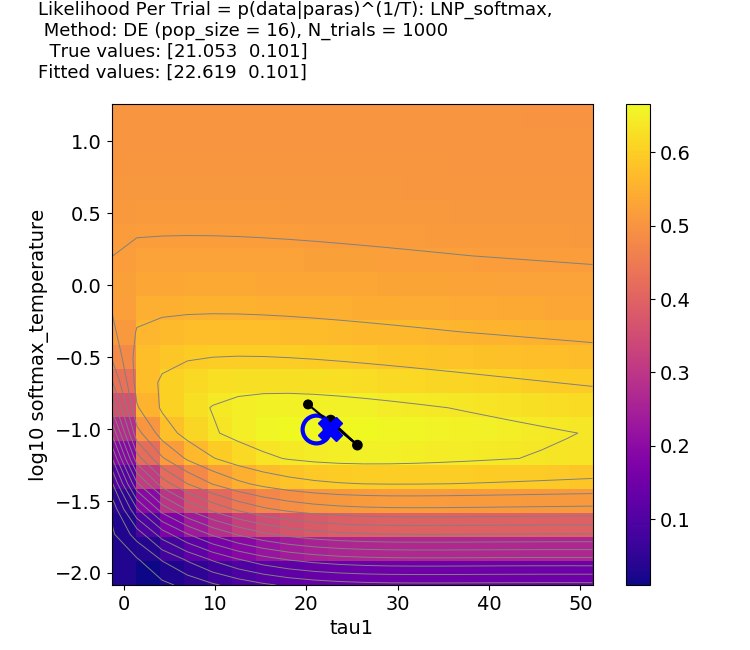

In [50]:
n_trials = 1000

forager = 'LNP_softmax'
para_names = ['tau1','softmax_temperature']
para_scales = ['linear','log']
para_bounds = [[1e-3,1e-2],[50,15]]

compute_LL_surface(forager, para_names, para_bounds, para_scales = para_scales,
                   true_para = [20, .1], n_trials = n_trials, 
                   fit_method = 'DE', n_x0s = 8, pool = pool)


`softmax_temperature` = 0.2

Adjusted true para on grid: [21.053  0.217]
Fitting using DE (pop_size = 16), pool = True...
Fitted para: [17.656  0.263]


LL_surface pair #0: 100%|███████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 236.62it/s]


<IPython.core.display.Javascript object>


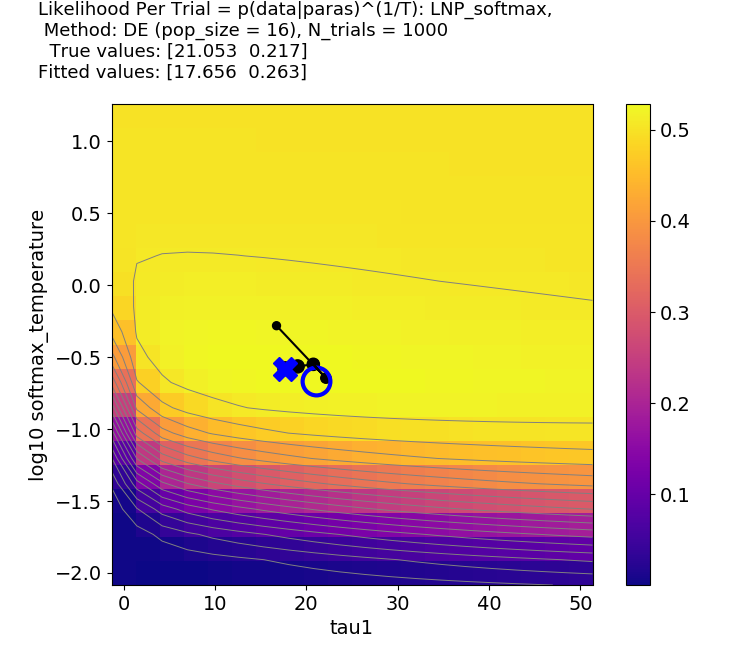

In [48]:
n_trials = 1000

forager = 'LNP_softmax'
para_names = ['tau1','softmax_temperature']
para_scales = ['linear','log']
para_bounds = [[1e-3,1e-2],[50,15]]

compute_LL_surface(forager, para_names, para_bounds, para_scales = para_scales, 
                   true_para = [20, .2], n_trials = n_trials, 
                   fit_method = 'DE', n_x0s = 8, pool = pool)


`softmax_temperature` = 1, the landscape is more flat, but still OK.

Adjusted true para on grid: [21.053  1.014]
Fitting using DE (pop_size = 16), pool = False...
Fitted para: [14.506  1.389]


LL_surface pair #0: 100%|███████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 236.06it/s]


<IPython.core.display.Javascript object>


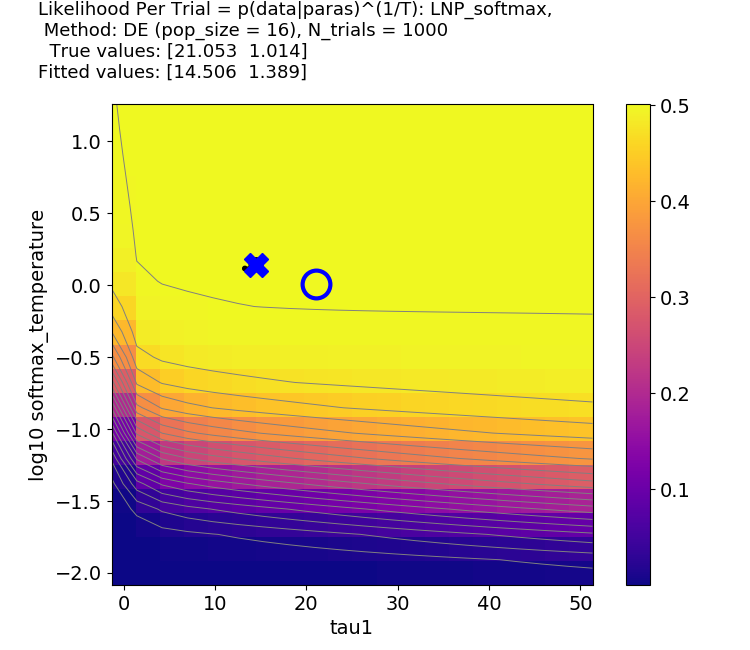

In [47]:
n_trials = 1000

forager = 'LNP_softmax'
para_names = ['tau1','softmax_temperature']
para_scales = ['linear','log']
para_bounds = [[1e-3,1e-2],[50,15]]

compute_LL_surface(forager, para_names, para_bounds, para_scales = para_scales,
                   true_para = [20, 1], n_trials = n_trials, 
                   fit_method = 'DE', n_x0s = 8, pool = '')


Large noise: `softmax_temperature` = 5, very bad.

Adjusted true para on grid: [21.053  4.727]
Fitting using DE (pop_size = 16), pool = False...
Fitted para: [50.     3.303]


LL_surface pair #0: 100%|███████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 237.88it/s]


<IPython.core.display.Javascript object>


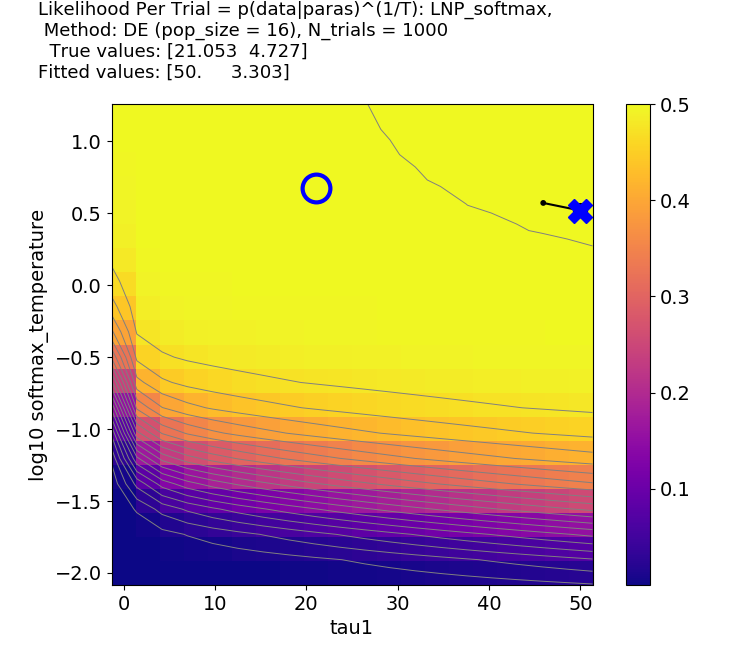

In [49]:
n_trials = 1000

forager = 'LNP_softmax'
para_names = ['tau1','softmax_temperature']
para_scales = ['linear','log']
para_bounds = [[1e-3,1e-2],[50,15]]

compute_LL_surface(forager, para_names, para_bounds, para_scales = para_scales, n_grids = [[20,20]], 
                   true_para = [20, 5], n_trials = n_trials, 
                   fit_method = 'DE', n_x0s = 8, pool = '')


#### 1.2.1 $\tau_1$, $\tau_2$, $w\_\tau_1$ and $\sigma$ (Corrado2005)

$\sigma$ is very accurate, but $\tau$s are not good. Presumably because they are also highly correlated?

Parameter Recovery, LNP_softmax: 100%|█████████████████████████████████████████████████| 30/30 [04:10<00:00,  8.35s/it]


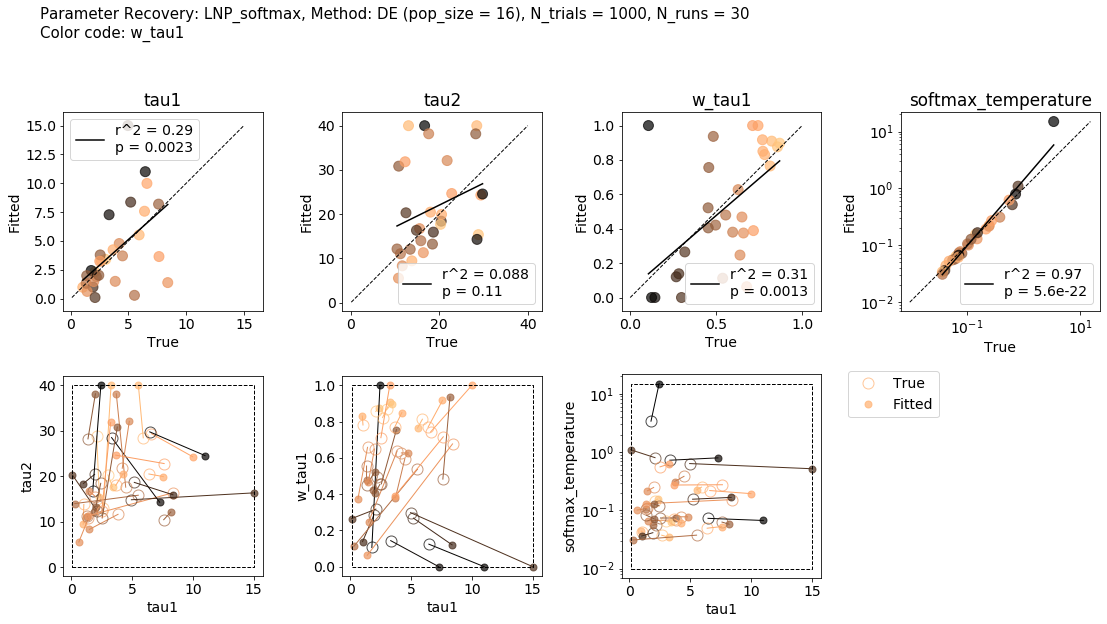

In [15]:
n_trials = 1000

forager = 'LNP_softmax'
para_names = ['tau1','tau2','w_tau1','softmax_temperature']
para_scales = ['linear','linear','linear','log']
para_bounds = [[1e-1, 1e-1, 0, 1e-2],
                [15  , 40,   1,  15]]

n_models = 30
true_paras = np.vstack((10**np.random.uniform(np.log10(1), np.log10(10), size = n_models),
                        10**np.random.uniform(np.log10(10), np.log10(30), size = n_models),
                        np.random.uniform(0.1, 0.9, size = n_models),
                        1/np.random.exponential(10, size = n_models))) # Inspired by Wilson 2019. I found beta ~ Exp(10) would be better

true_paras, fitted_para = fit_para_recovery(forager, 
              para_names, para_bounds, true_paras, n_trials = n_trials, 
              para_scales = para_scales, para_color_code = 2, para_2ds = [[0,1],[0,2],[0,3]],
              fit_method = 'DE', pool = pool);    


Try log scales, looks better for taus.

Parameter Recovery, LNP_softmax: 100%|█████████████████████████████████████████████████| 30/30 [03:40<00:00,  7.36s/it]


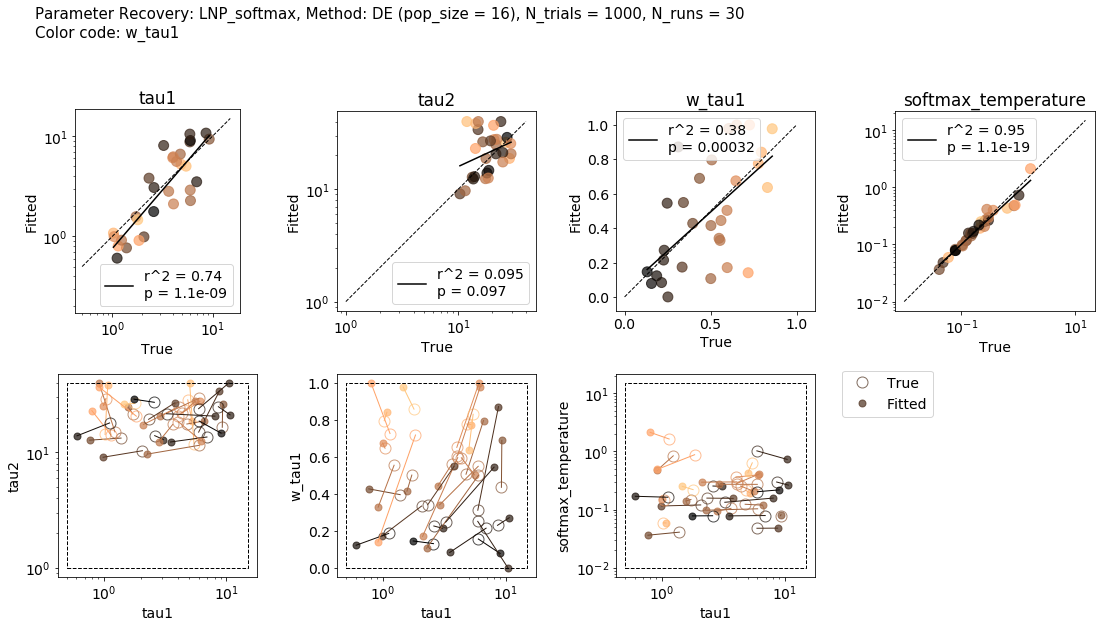

In [21]:
n_trials = 1000

forager = 'LNP_softmax'
para_names = ['tau1','tau2','w_tau1','softmax_temperature']
para_scales = ['log','log','linear','log']
para_bounds = [[5e-1, 1, 0, 1e-2],
                [15  , 40,   1,  15]]

n_models = 30
true_paras = np.vstack((10**np.random.uniform(np.log10(1), np.log10(10), size = n_models),
                        10**np.random.uniform(np.log10(10), np.log10(30), size = n_models),
                        np.random.uniform(0.1, 0.9, size = n_models),
                        1/np.random.exponential(10, size = n_models))) # Inspired by Wilson 2019. I found beta ~ Exp(10) would be better

true_paras, fitted_para = fit_para_recovery(forager, 
              para_names, para_bounds, true_paras, n_trials = n_trials, 
              para_scales = para_scales, para_color_code = 2, para_2ds = [[0,1],[0,2],[0,3]],
              fit_method = 'DE', pool = pool);    


Multiple Log likelihood landscapes, each of which is sliced across the corresponding 2-D parameter space that intercepts the fitted values. These plots could give us a sense of both accuracy (bias of X from O) and precision (the shape of contours around X) of the fitting given the observed fitted values.

Here I use the fitted parameters in Corrado2005. It seems that their fittings were quite reliable.

Adjusted true para on grid: [ 1.886 17.505  0.345  0.16 ]
Fitting using DE (pop_size = 16), pool = True...
Fitted para: [ 3.282 16.331  0.433  0.171]


LL_surface pair #5: 100%|███████████████████████████████████████████████████████████| 900/900 [00:02<00:00, 332.01it/s]


<IPython.core.display.Javascript object>


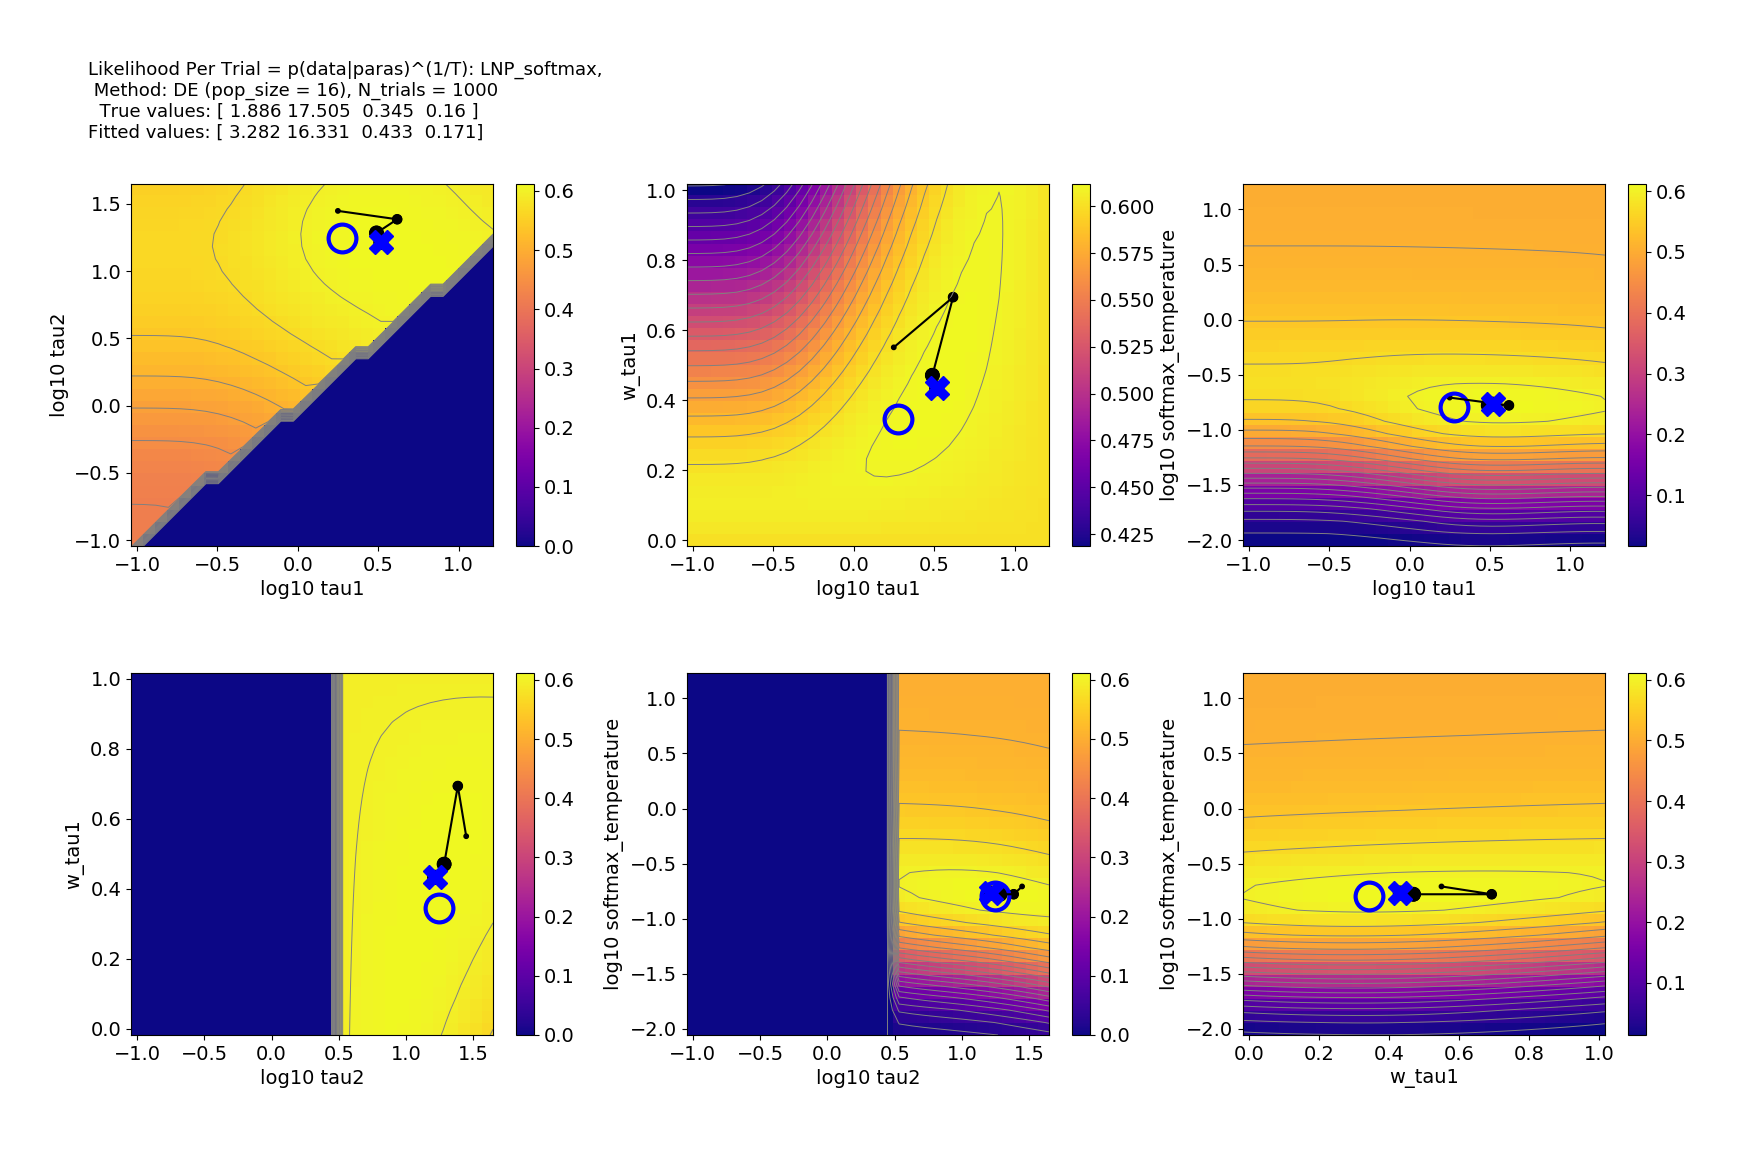

In [61]:
n_trials = 1000

forager = 'LNP_softmax'
para_names = ['tau1','tau2','w_tau1','softmax_temperature']
para_scales = ['log','log','linear','log']
para_bounds = [[1e-1, 1e-1, 0, 1e-2],
                [15  , 40,   1,  15]]

# -- LL_surface (see the gradient around Corrado 2005 results)
compute_LL_surface(forager, para_names, para_bounds, 
                    true_para = [2, 16, 0.33, 0.15], # Corrado 2005 fitting results
                    para_2ds = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]], # LL surfaces for user-defined pairs of paras
                    n_grids = [[30,30]] * 6, 
                    para_scales = para_scales,
                    DE_pop_size = 16,
                    n_trials = n_trials,
                    fit_method = 'DE', n_x0s = 8, pool = pool)


If we increase the trial number to 10,000 (by, e.g, pooling ~10 stable sessions together), the results are just perfect!!

Adjusted true para on grid: [ 1.886 17.505  0.345  0.16 ]
Fitting using DE (pop_size = 16), pool = True...
Fitted para: [ 2.085 19.158  0.364  0.153]


LL_surface pair #5: 100%|████████████████████████████████████████████████████████████| 900/900 [00:35<00:00, 25.11it/s]


<IPython.core.display.Javascript object>


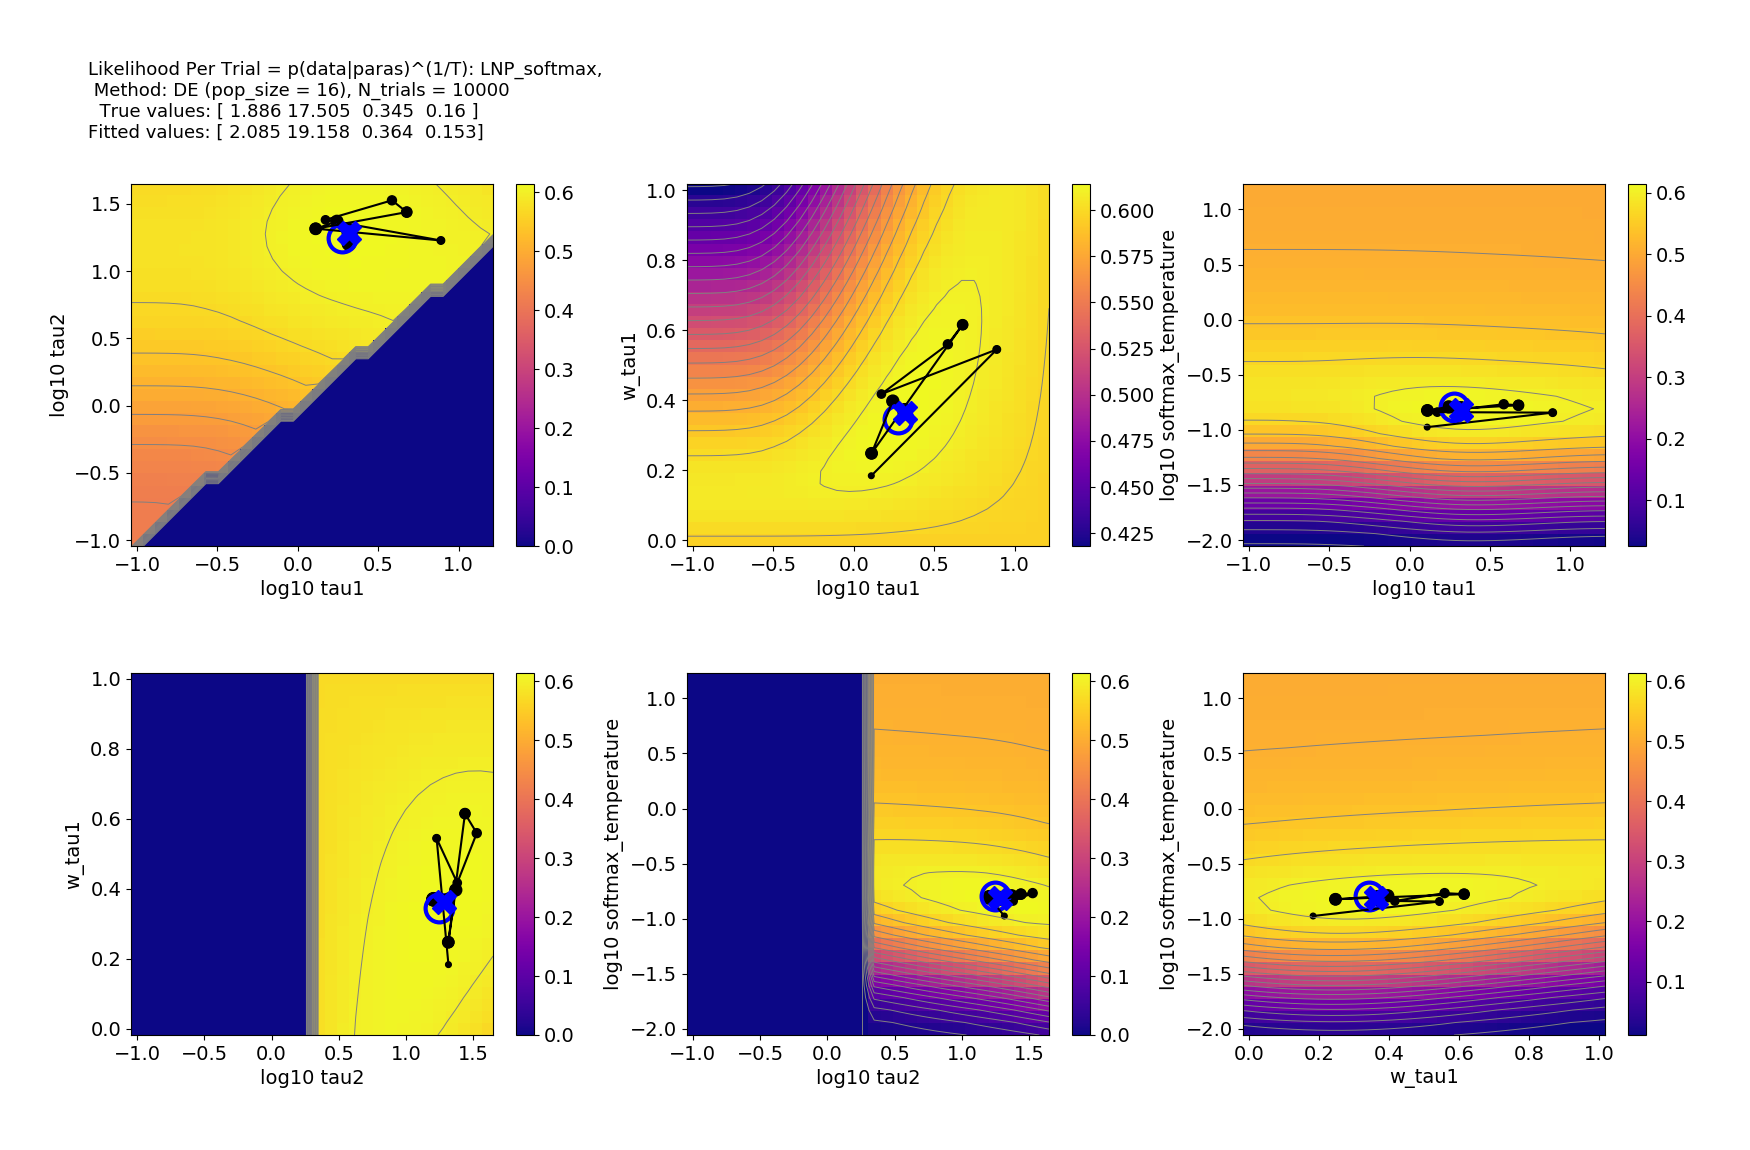

In [62]:
n_trials = 10000

forager = 'LNP_softmax'
para_names = ['tau1','tau2','w_tau1','softmax_temperature']
para_scales = ['log','log','linear','log']
para_bounds = [[1e-1, 1e-1, 0, 1e-2],
                [15  , 40,   1,  15]]

# -- LL_surface (see the gradient around Corrado 2005 results)
compute_LL_surface(forager, para_names, para_bounds, 
                    true_para = [2, 16, 0.33, 0.15], # Corrado 2005 fitting results
                    para_2ds = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]], # LL surfaces for user-defined pairs of paras
                    n_grids = [[30,30]] * 6, 
                    para_scales = para_scales,
                    DE_pop_size = 16,
                    n_trials = n_trials,
                    fit_method = 'DE', n_x0s = 8, pool = pool)


Try the paras that optimize rewards in Foraging_Testbed. Not so good even when `n_trials = 10000`. This is because the optimal weight of $\tau_1$ is very close to 1, meaning that this model should be reduced to having only one $\tau$.

Adjusted true para on grid: [ 6.323 32.534  0.966  0.206]
Fitting using DE (pop_size = 16), pool = True...
Fitted para: [5.547 8.734 0.728 0.208]


LL_surface pair #5: 100%|████████████████████████████████████████████████████████████| 900/900 [00:37<00:00, 23.91it/s]


<IPython.core.display.Javascript object>


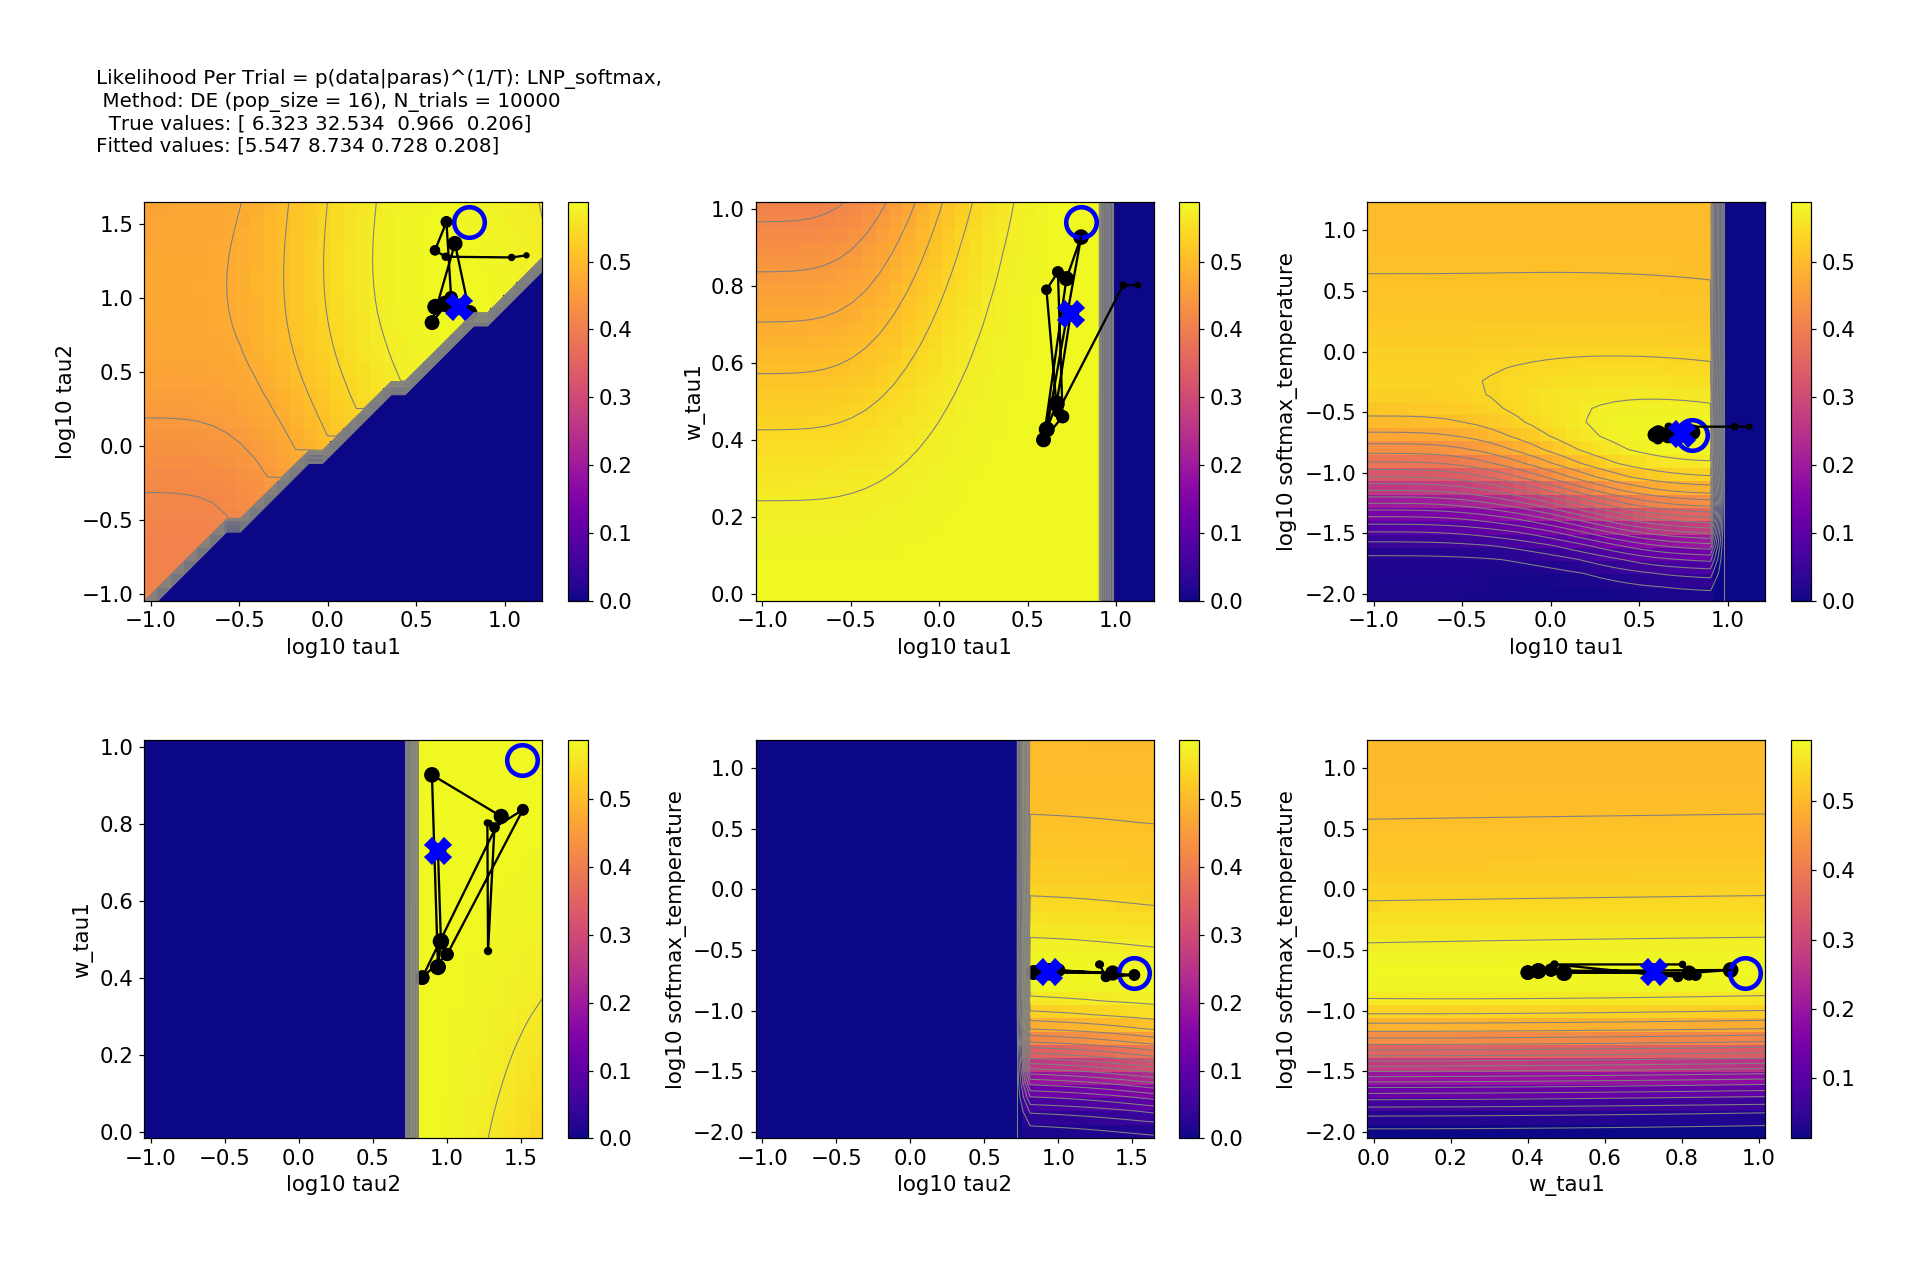

In [12]:
n_trials = 10000

forager = 'LNP_softmax'
para_names = ['tau1','tau2','w_tau1','softmax_temperature']
para_scales = ['log','log','linear','log']
para_bounds = [[1e-1, 1e-1, 0, 1e-2],
                [15  , 40,   1,  15]]

# -- LL_surface (see the gradient around Corrado 2005 results)
compute_LL_surface(forager, para_names, para_bounds, 
                    true_para = [6.17853872, 30.31342409, 1-0.04822465, 0.18704151], # Paras that optimize rewards
                    para_2ds = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]], # LL surfaces for user-defined pairs of paras
                    n_grids = [[30,30]] * 6, 
                    para_scales = para_scales,
                    DE_pop_size = 16,
                    n_trials = n_trials,
                    fit_method = 'DE', n_x0s = 8, pool = pool)


### 1.3 RW1972_Epsilon and RW1972_Softmax

#### 1.3.1 `RW1972_epsi`: $\alpha$ and $\epsilon$

The results depend on learning rate $\alpha$ heavily.

Parameter Recovery, RW1972_epsi: 100%|█████████████████████████████████████████████████| 50/50 [05:21<00:00,  6.43s/it]


<IPython.core.display.Javascript object>


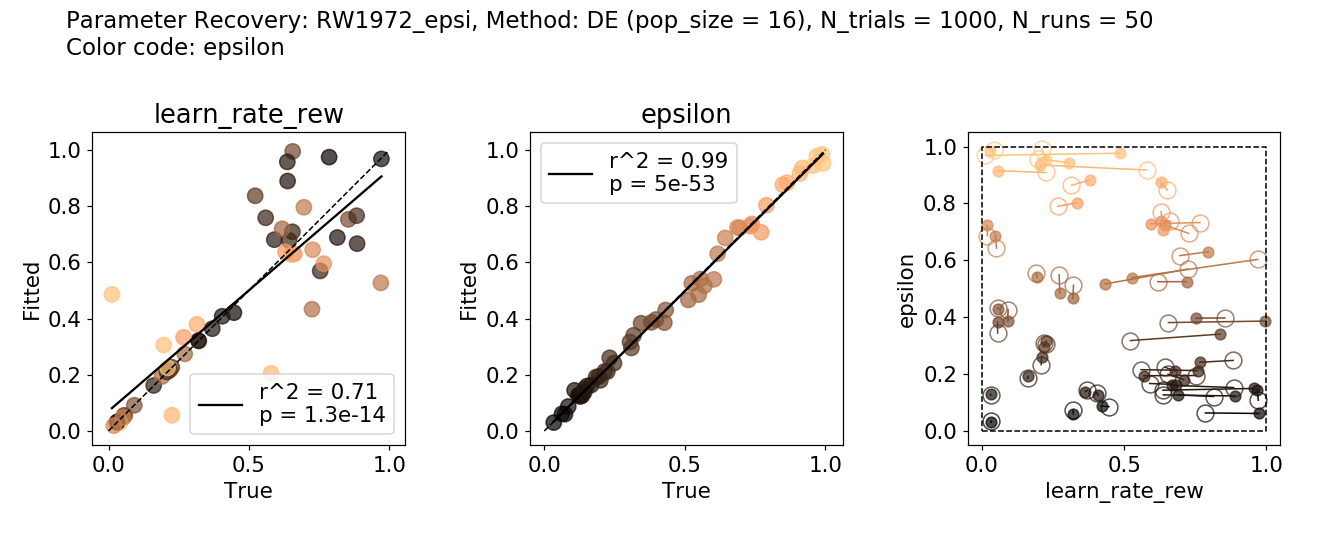

In [6]:
n_trials = 1000

forager = 'RW1972_epsi'
para_names = ['learn_rate_rew','epsilon']
para_scales = ['linear','linear']
para_bounds = [[0, 0],
                [1, 1]]

#-- Para recovery
n_models = 50
true_paras = np.vstack((np.random.uniform(0, 1, size = n_models),
                        np.random.uniform(0, 1, size = n_models),
                        ))
true_paras, fitted_para = fit_para_recovery(forager, 
              para_names, para_bounds, true_paras, n_trials = n_trials, 
              para_scales = para_scales, para_color_code = 1, para_2ds = [[0,1]],
              fit_method = 'DE', pool = pool);    


This is because the effective time constant $\tau_{eff}$ is smaller than 1 when $\alpha$ is larger than 0.63, which makes it difficult to differentiate (and will never happen in reality). But see [RW1972_softmax](#1.3.2-RW1972_softmax:-$\alpha$-and-$\sigma$) (I don't know why... because softmax is adaptive?)

<IPython.core.display.Javascript object>


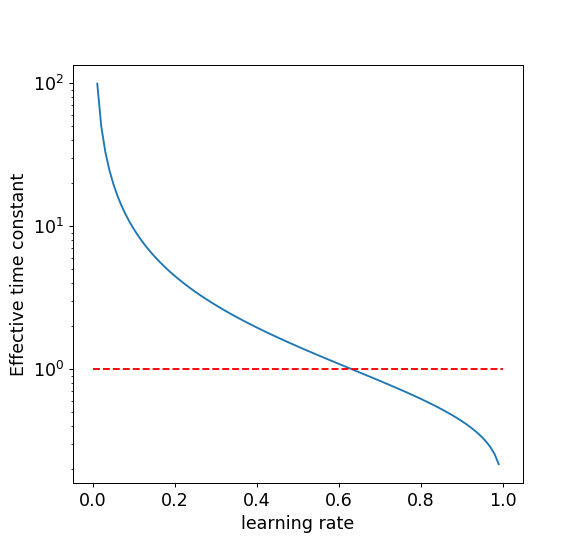

In [24]:
alpha = np.linspace(0.01,0.99,100);
plt.plot(alpha, -1/np.log(1-(alpha)),'-')
plt.plot([0,1],[1,1],'r--')
plt.yscale('log')
plt.xlabel('learning rate')
plt.ylabel('Effective time constant');

$\alpha$ = 0.1 ($\tau_{eff}\approx10$), $\epsilon=0.1$, perfect.

Adjusted true para on grid: [0.103 0.207]
Fitting using DE (pop_size = 16), pool = True...
Fitted para: [0.104 0.228]


LL_surface pair #0: 100%|███████████████████████████████████████████████████████████| 900/900 [00:03<00:00, 240.32it/s]


<IPython.core.display.Javascript object>


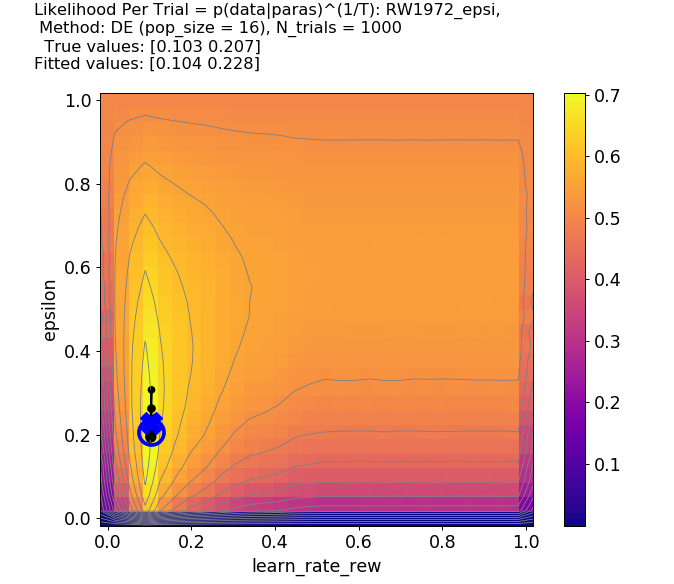

In [29]:
n_trials = 1000

forager = 'RW1972_epsi'
para_names = ['learn_rate_rew','epsilon']
para_scales = ['linear','linear']
para_bounds = [[0, 0],
                [1, 1]]

# -- LL_surface --
compute_LL_surface(forager, para_names, para_bounds, 
                    true_para = [0.1, 0.2], 
                    para_2ds = [[0,1]], # LL surfaces for user-defined pairs of paras
                    n_grids = [[30,30]] * 6, 
                    para_scales = para_scales,
                    n_trials = n_trials,
                    fit_method = 'DE', n_x0s = 8, pool = pool)


Larger `epsilon`, still good.

Adjusted true para on grid: [0.103 0.793]
Fitting using DE (pop_size = 16), pool = True...
Fitted para: [0.099 0.741]


LL_surface pair #0: 100%|███████████████████████████████████████████████████████████| 900/900 [00:03<00:00, 236.54it/s]


<IPython.core.display.Javascript object>


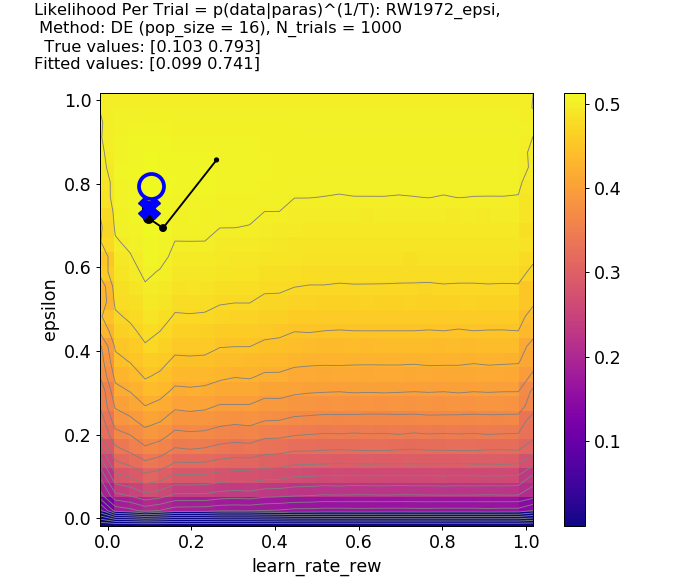

In [28]:
n_trials = 1000

forager = 'RW1972_epsi'
para_names = ['learn_rate_rew','epsilon']
para_scales = ['linear','linear']
para_bounds = [[0, 0],
                [1, 1]]

# -- LL_surface --
compute_LL_surface(forager, para_names, para_bounds, 
                    true_para = [0.1, 0.8],
                    para_2ds = [[0,1]], # LL surfaces for user-defined pairs of paras
                    n_grids = [[30,30]] * 6, 
                    para_scales = para_scales,
                    n_trials = n_trials,
                    fit_method = 'DE', n_x0s = 8, pool = pool)


But $\alpha$ = 0.8, hard to differentiate. This should never happen in reality.

Adjusted true para on grid: [0.793 0.483]
Fitting using DE (pop_size = 16), pool = True...
Fitted para: [0.906 0.49 ]


LL_surface pair #0: 100%|███████████████████████████████████████████████████████████| 900/900 [00:03<00:00, 240.83it/s]


<IPython.core.display.Javascript object>


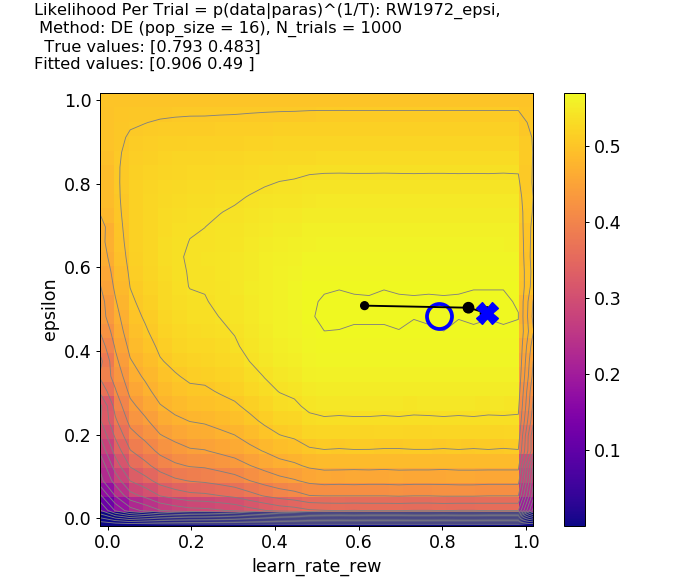

In [27]:
n_trials = 1000

forager = 'RW1972_epsi'
para_names = ['learn_rate_rew','epsilon']
para_scales = ['linear','linear']
para_bounds = [[0, 0],
                [1, 1]]

# -- LL_surface --
compute_LL_surface(forager, para_names, para_bounds, 
                    true_para = [0.8, 0.5],
                    para_2ds = [[0,1]], # LL surfaces for user-defined pairs of paras
                    n_grids = [[30,30]] * 6, 
                    para_scales = para_scales,
                    n_trials = n_trials,
                    fit_method = 'DE', n_x0s = 8, pool = pool)


#### 1.3.2 `RW1972_softmax`: $\alpha$ and $\sigma$

Similar to [Sugrue2004 here](#1.2.1-$\tau_1$-and-$\sigma$-(Sugrue2004-but-with-softmax)-).
But compared with [RW1972_epsilon](#1.3.1-RW1972_epsi:-$\alpha$-and-$\epsilon$), this even works for $\alpha$>0.6!!!

Parameter Recovery, RW1972_softmax: 100%|██████████████████████████████████████████████| 50/50 [02:34<00:00,  3.09s/it]


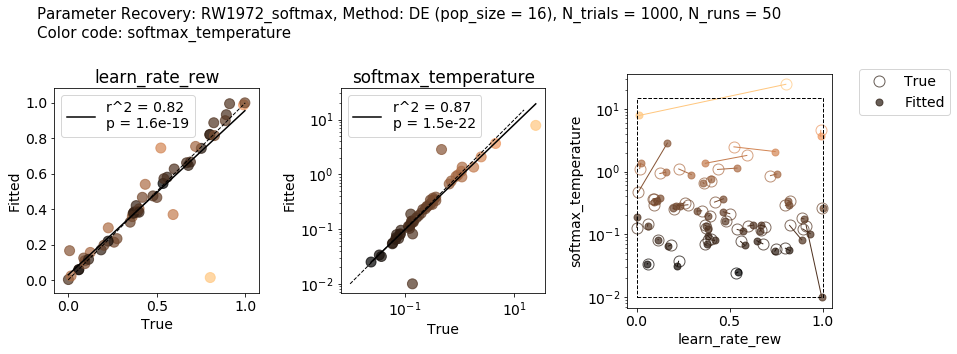

In [13]:
n_trials = 1000

forager = 'RW1972_softmax'

para_names = ['learn_rate_rew','softmax_temperature']
para_scales = ['linear','log']
para_bounds = [[0, 1e-2],
                [1, 15]]

#-- Para recovery
n_models = 50
true_paras = np.vstack((np.random.uniform(0, 1, size = n_models),
                        1/np.random.exponential(10, size = n_models),
                        ))
true_paras, fitted_para = fit_para_recovery(forager, 
              para_names, para_bounds, true_paras, n_trials = n_trials, 
              para_scales = para_scales, para_color_code = 1, para_2ds = [[0,1]],
              fit_method = 'DE', pool = pool);    

Its LL surface is a mango :)

Adjusted true para on grid: [0.207 0.439]
Fitting using DE (pop_size = 16), pool = True...
Fitted para: [0.255 0.503]


LL_surface pair #0: 100%|███████████████████████████████████████████████████████████| 900/900 [00:03<00:00, 246.96it/s]


<IPython.core.display.Javascript object>


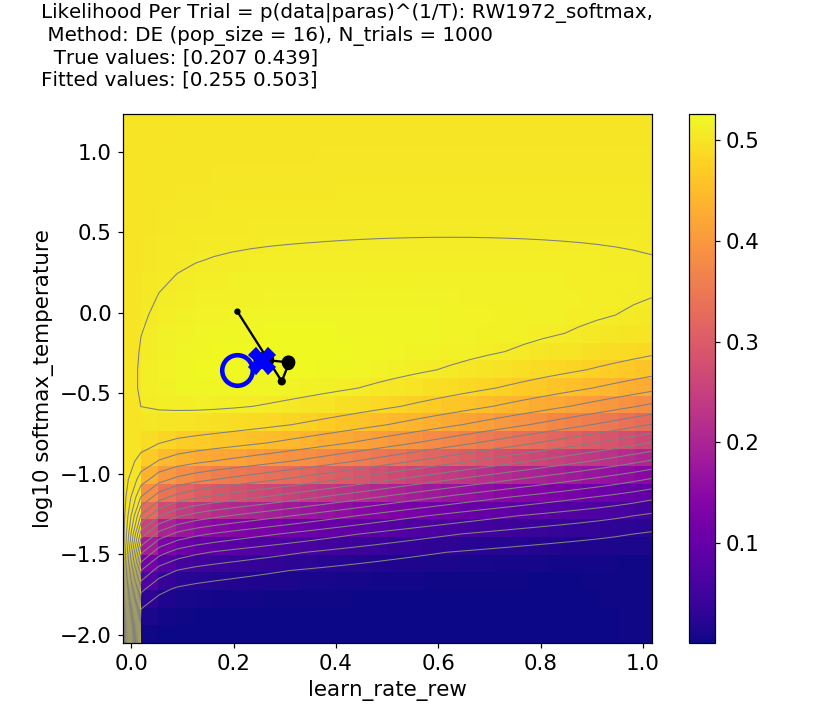

In [10]:
n_trials = 1000

forager = 'RW1972_softmax'
para_names = ['learn_rate_rew','softmax_temperature']
para_scales = ['linear','log']
para_bounds = [[0, 1e-2],
                [1, 15]]

# -- LL_surface --
compute_LL_surface(forager, para_names, para_bounds, 
                    true_para = [0.2, 0.4],
                    para_2ds = [[0,1]], # LL surfaces for user-defined pairs of paras
                    n_grids = [[30,30]] * 6, 
                    para_scales = para_scales,
                    n_trials = n_trials,
                    fit_method = 'DE', n_x0s = 8, pool = pool)


Even works well for $\alpha$>0.6!!!

Fitting using DE (pop_size = 16), pool = True...
  True para: [0.8 0.4]
Fitted para: [0.751 0.363]


LL_surface pair #0: 100%|███████████████████████████████████████████████████████████| 900/900 [00:03<00:00, 276.15it/s]


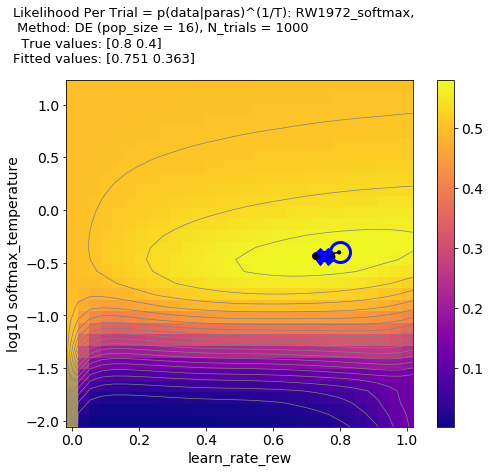

In [3]:
n_trials = 1000

forager = 'RW1972_softmax'
para_names = ['learn_rate_rew','softmax_temperature']
para_scales = ['linear','log']
para_bounds = [[0, 1e-2],
                [1, 15]]

# -- LL_surface --
compute_LL_surface(forager, para_names, para_bounds, 
                    true_para = [0.8, 0.4],
                    para_2ds = [[0,1]], # LL surfaces for user-defined pairs of paras
                    n_grids = [[30,30]] * 6, 
                    para_scales = para_scales,
                    n_trials = n_trials,
                    fit_method = 'DE', n_x0s = 8, pool = pool)


### 1.4 Bari 2019: $\alpha$, $\delta$, $\sigma$

Not perfect, but good.

Parameter Recovery, Bari2019: 100%|████████████████████████████████████████████████████| 50/50 [04:21<00:00,  5.23s/it]


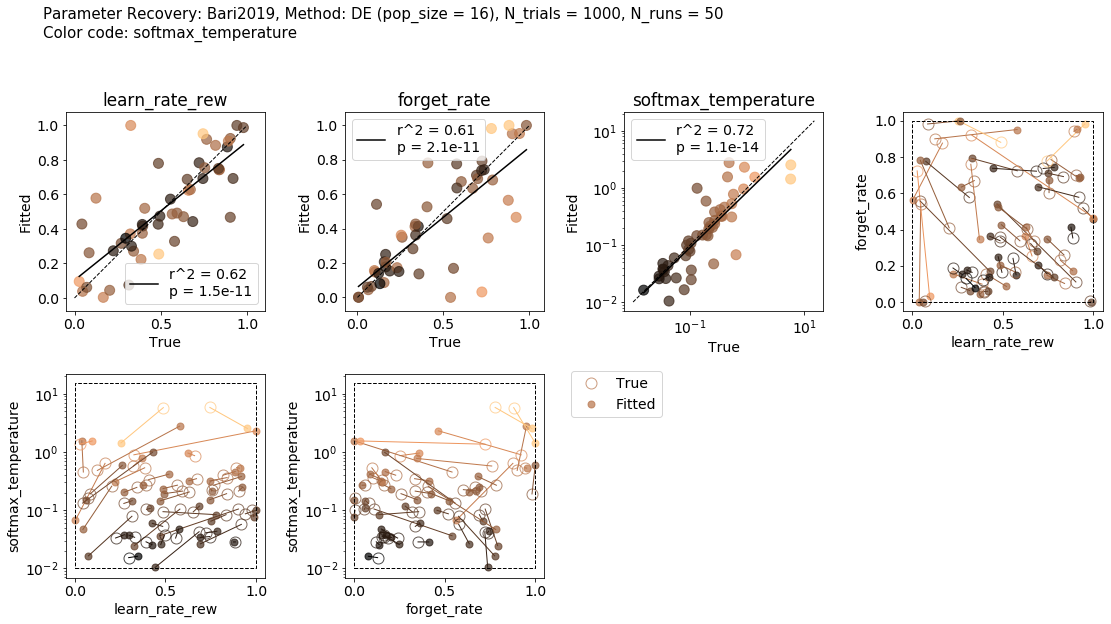

In [12]:
n_trials = 1000

forager = 'Bari2019'
para_names = ['learn_rate_rew','forget_rate','softmax_temperature']
para_scales = ['linear','linear', 'log']
para_bounds = [[0, 0, 1e-2],
                [1, 1, 15]]

#-- Para recovery
n_models = 50
true_paras = np.vstack((np.random.uniform(0, 1, size = n_models),
                        np.random.uniform(0, 1, size = n_models),
                        1/np.random.exponential(10, size = n_models),
                        ))
true_paras, fitted_para = fit_para_recovery(forager, 
              para_names, para_bounds, true_paras, n_trials = n_trials, 
              para_scales = para_scales, para_color_code = 2, para_2ds = [[0,1],[0,2],[1,2]],
              fit_method = 'DE', pool = pool);    

Try 10,000 trials. Perfect! (You may not want to rerun this... too slow)

Parameter Recovery, Bari2019: 100%|████████████████████████████████████████████████████| 50/50 [37:34<00:00, 45.10s/it]


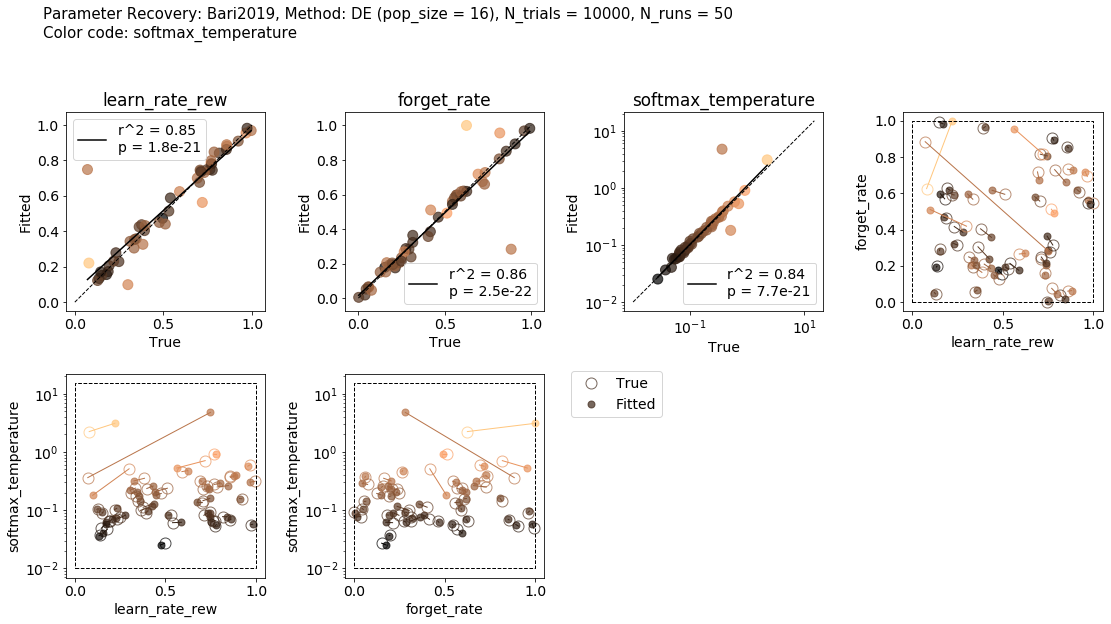

In [17]:
n_trials = 10000

forager = 'Bari2019'
para_names = ['learn_rate_rew','forget_rate','softmax_temperature']
para_scales = ['linear','linear', 'log']
para_bounds = [[0, 0, 1e-2],
                [1, 1, 15]]

#-- Para recovery
n_models = 50
true_paras = np.vstack((np.random.uniform(0, 1, size = n_models),
                        np.random.uniform(0, 1, size = n_models),
                        1/np.random.exponential(10, size = n_models),
                        ))
true_paras, fitted_para = fit_para_recovery(forager, 
              para_names, para_bounds, true_paras, n_trials = n_trials, 
              para_scales = para_scales, para_color_code = 2, para_2ds = [[0,1],[0,2],[1,2]],
              fit_method = 'DE', pool = pool);    

Or, it seems good with values that optimize reward, even for 1000 trials.

Adjusted true para on grid: [0.204 0.02  0.198]
Fitting using DE (pop_size = 16), pool = True...
Fitted para: [0.186 0.052 0.187]


LL_surface pair #2: 100%|█████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 300.71it/s]


<IPython.core.display.Javascript object>


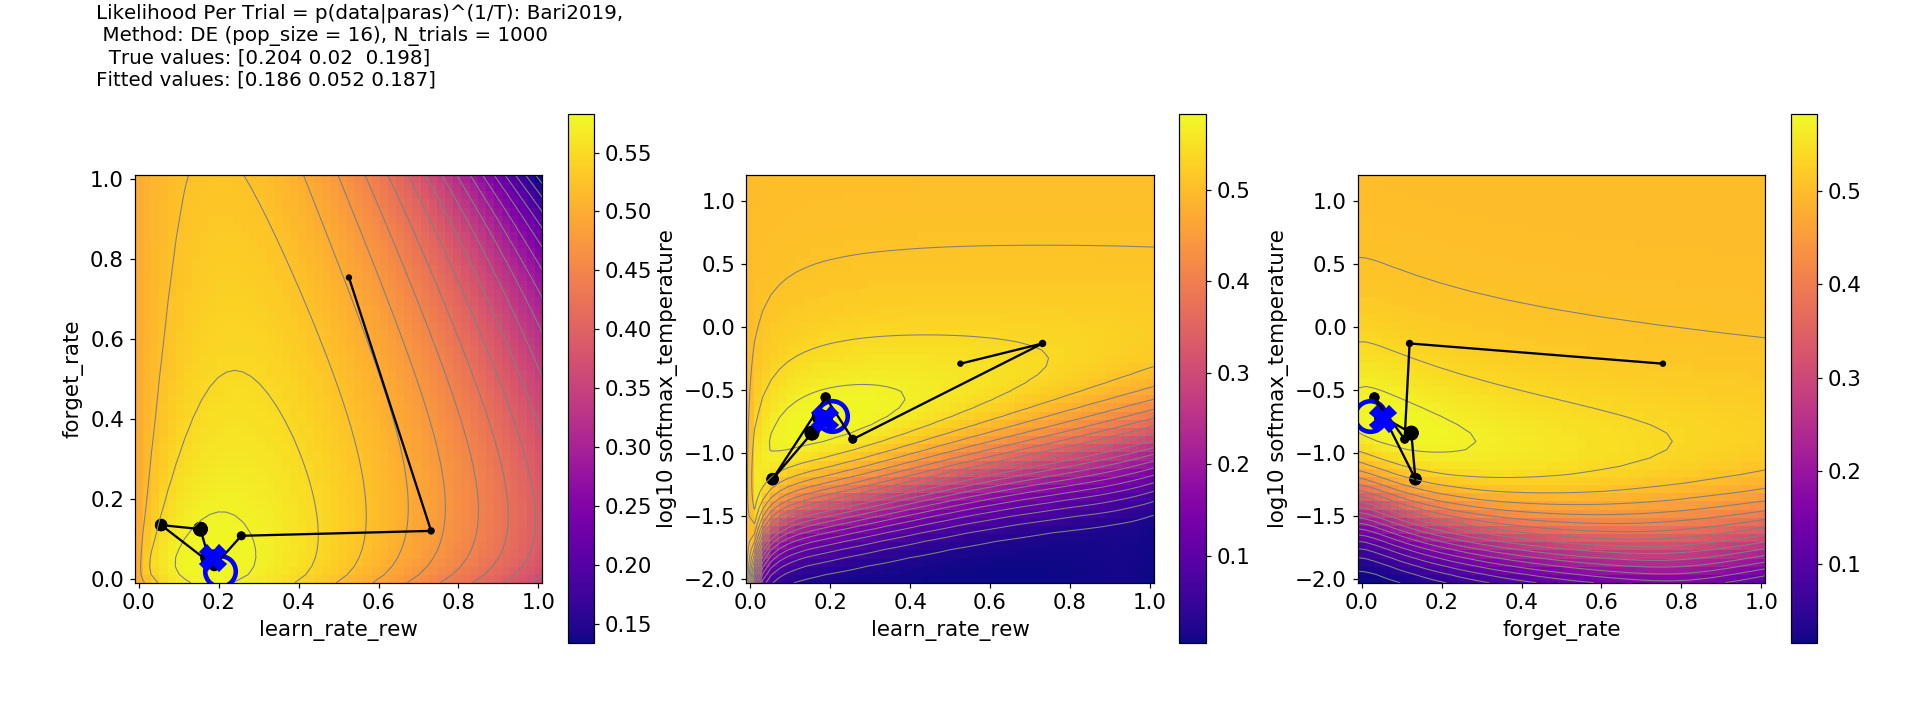

In [10]:
n_trials = 1000

forager = 'Bari2019'
para_names = ['learn_rate_rew','forget_rate','softmax_temperature']
para_scales = ['linear','linear', 'log']
para_bounds = [[0, 0, 1e-2],
                [1, 1, 15]]

# -- LL_surface --
compute_LL_surface(forager, para_names, para_bounds, 
                    true_para = [0.1976758, 0.01164267, 0.19536022],  # Use values that optimize reward
                    para_2ds = [[0,1],[0,2],[1,2]], # LL surfaces for user-defined pairs of paras
                    n_grids = [[50,50]] * 6, 
                    para_scales = para_scales,
                    n_trials = n_trials,
                    fit_method = 'DE', n_x0s = 8, pool = pool)


### 1.5 Hattori 2019: $\alpha_0$, $\alpha_1$, $\delta$, $\sigma$

Parameter Recovery, Hattori2019: 100%|█████████████████████████████████████████████████| 30/30 [03:50<00:00,  7.67s/it]


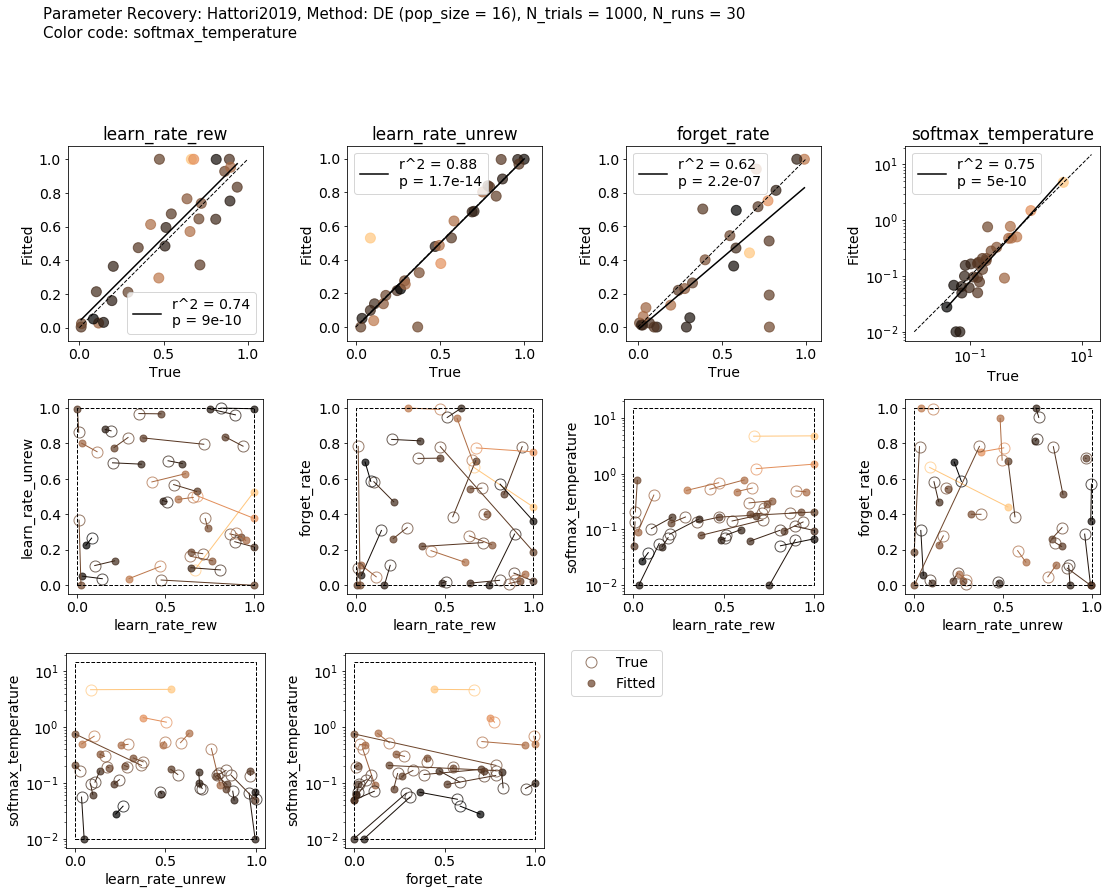

In [11]:
n_trials = 1000

forager = 'Hattori2019'
para_names = ['learn_rate_rew','learn_rate_unrew', 'forget_rate','softmax_temperature']
para_scales = ['linear','linear','linear', 'log']
para_bounds = [[0, 0, 0, 1e-2],
               [1, 1, 1, 15]]

#-- Para recovery
n_models = 30
true_paras = np.vstack((np.random.uniform(0, 1, size = n_models),
                        np.random.uniform(0, 1, size = n_models),
                        np.random.uniform(0, 1, size = n_models),
                        1/np.random.exponential(10, size = n_models),
                        ))
true_paras, fitted_para = fit_para_recovery(forager, 
              para_names, para_bounds, true_paras, n_trials = n_trials, 
              para_scales = para_scales, para_color_code = 3, para_2ds = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]],
              fit_method = 'DE', pool = pool);    

Use values that optimize reward. Good.

Fitting using DE (pop_size = 16), pool = True...
  True para: [0.4  0.2  0.2  0.25]
Fitted para: [0.455 0.176 0.198 0.27 ]
km = 4, AIC = 948.268, BIC = 967.899
      LPT_AIC = 0.622, LPT_BIC = 0.616


LL_surface pair #5: 100%|███████████████████████████████████████████████████████████| 900/900 [00:03<00:00, 295.58it/s]


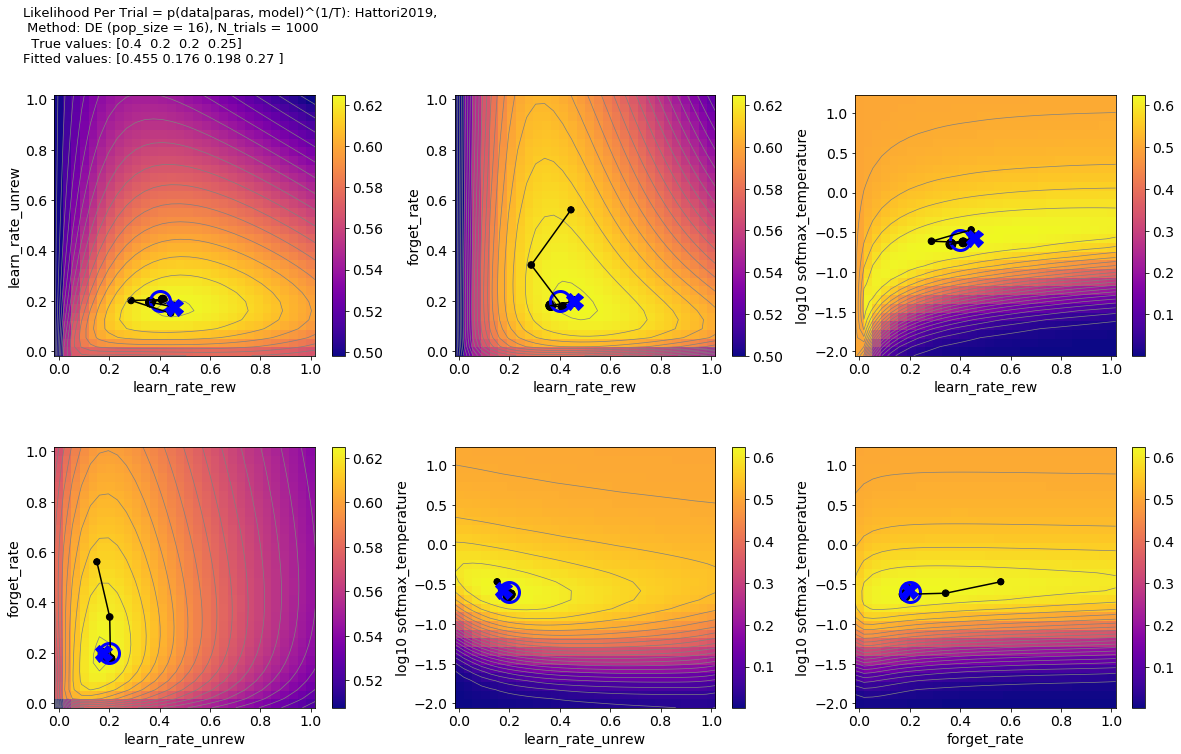

In [2]:
n_trials = 1000

forager = 'Hattori2019'
para_names = ['learn_rate_rew','learn_rate_unrew', 'forget_rate','softmax_temperature']
para_scales = ['linear','linear','linear', 'log']
para_bounds = [[0, 0, 0, 1e-2],
               [1, 1, 1, 15]]

# -- LL_surface --
compute_LL_surface(forager, para_names, para_bounds, 
                    true_para = [0.4, 0.2, 0.2, 0.25],  # Almost Hattori et al.
                    para_2ds = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]], # LL surfaces for user-defined pairs of paras
                    n_grids = [[30,30]] * 6, 
                    para_scales = para_scales,
                    n_trials = n_trials,
                    fit_method = 'DE', n_x0s = 8, pool = pool)


Now let's try a variant of `Hattori2019`, i.e., $\delta=0$. It works.

Fitting using DE (pop_size = 16), pool = True...
  True para: [0.4  0.2  0.   0.25]
Fitted para: [0.533 0.179 0.    0.265]
km = 3, AIC = 1060.67, BIC = 1075.4
      LPT_AIC = 0.588, LPT_BIC = 0.584


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:1154: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5
LL_surface pair #5: 100%|███████████████████████████████████████████████████████████| 900/900 [00:03<00:00, 283.24it/s]


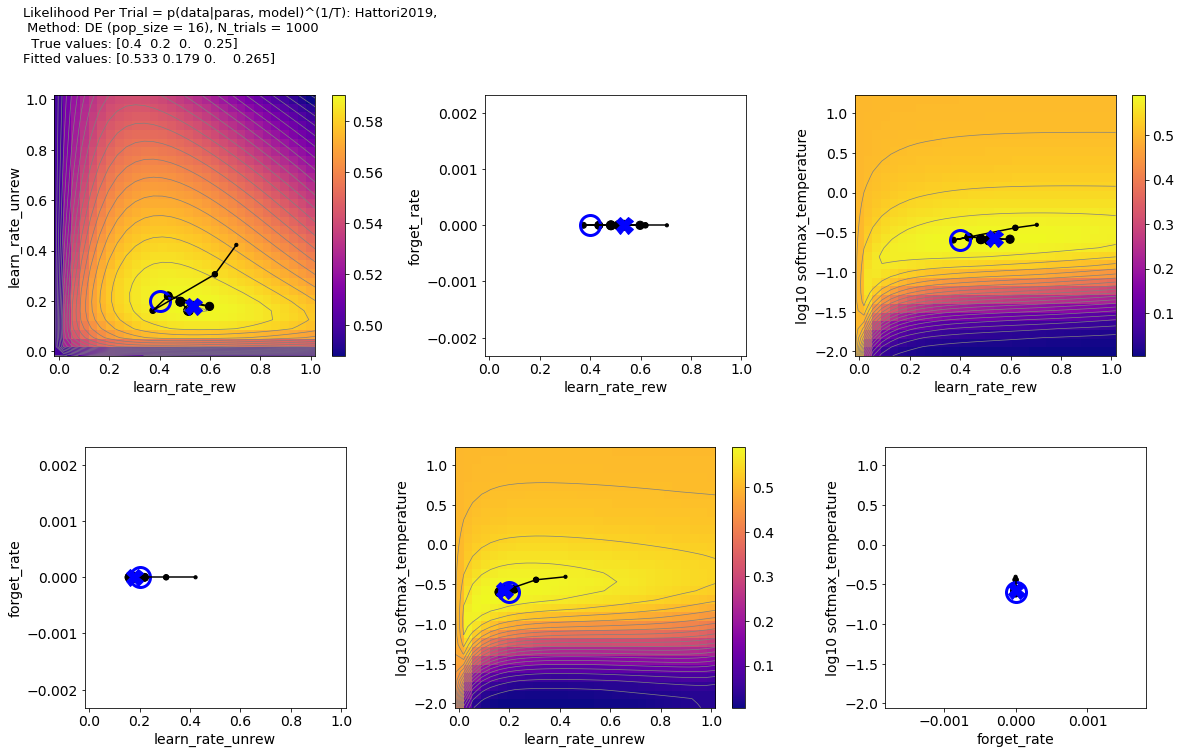

In [3]:
n_trials = 1000

forager = 'Hattori2019'
para_names = ['learn_rate_rew','learn_rate_unrew', 'forget_rate','softmax_temperature']
para_scales = ['linear','linear','linear', 'log']
para_bounds = [[0, 0, 0, 1e-2],
               [1, 1, 0, 15]]

# -- LL_surface --
compute_LL_surface(forager, para_names, para_bounds, 
                    true_para = [0.4, 0.2, 0, 0.25],  # Almost Hattori et al.
                    para_2ds = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]], # LL surfaces for user-defined pairs of paras
                    n_grids = [[30,30]] * 6, 
                    para_scales = para_scales,
                    n_trials = n_trials,
                    fit_method = 'DE', n_x0s = 8, pool = pool)


Or, equivalently, we can directly omit the `forget_rate` term for `Hattori2019`. It is set to 0 automatically.

Fitting using DE (pop_size = 16), pool = True...
  True para: [0.4  0.2  0.25]
Fitted para: [0.437 0.218 0.274]
km = 3, AIC = 1104.72, BIC = 1119.44
      LPT_AIC = 0.576, LPT_BIC = 0.571


LL_surface pair #2: 100%|███████████████████████████████████████████████████████████| 900/900 [00:03<00:00, 299.60it/s]


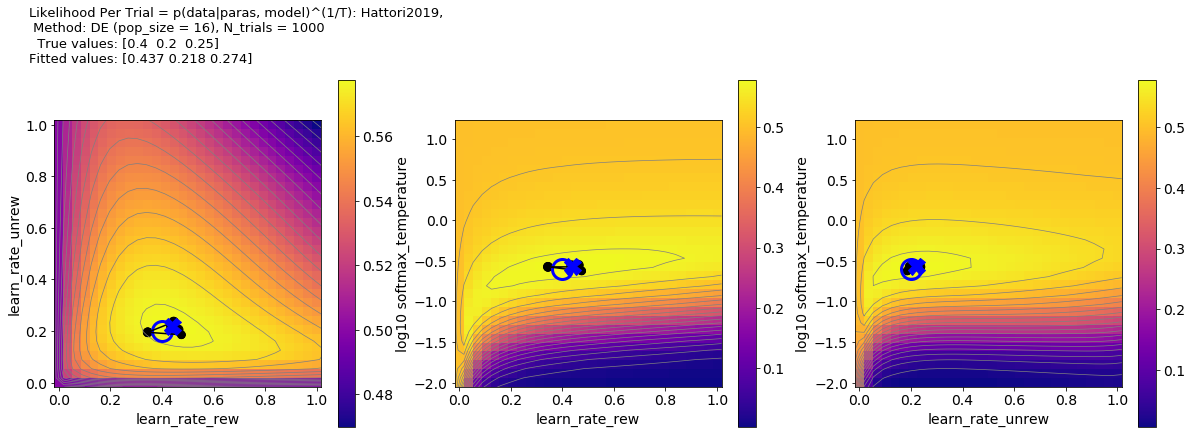

In [7]:
n_trials = 1000

forager = 'Hattori2019'
para_names = ['learn_rate_rew','learn_rate_unrew','softmax_temperature']
para_scales = ['linear','linear', 'log']
para_bounds = [[0, 0, 1e-2],
               [1, 1, 15]]

# -- LL_surface --
compute_LL_surface(forager, para_names, para_bounds, 
                    true_para = [0.4, 0.2, 0.25],  # Almost Hattori et al.
                    para_2ds = [[0,1],[0,2],[1,2]], # LL surfaces for user-defined pairs of paras
                    n_grids = [[30,30]] * 6, 
                    para_scales = para_scales,
                    n_trials = n_trials,
                    fit_method = 'DE', n_x0s = 8, pool = pool)


Try a wrong model: use true forget_rate = 0.3, but do not use forget_rate in fitting (bound = [0,0]). Note the other parameters are largely biased.

Fitting using DE (pop_size = 16), pool = True...
  True para: [0.4  0.2  0.2  0.25]
Fitted para: [0.048 0.221 0.    0.056]
km = 3, AIC = 1080.58, BIC = 1095.3
      LPT_AIC = 0.583, LPT_BIC = 0.578


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:1154: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5
LL_surface pair #5: 100%|███████████████████████████████████████████████████████████| 900/900 [00:03<00:00, 287.94it/s]


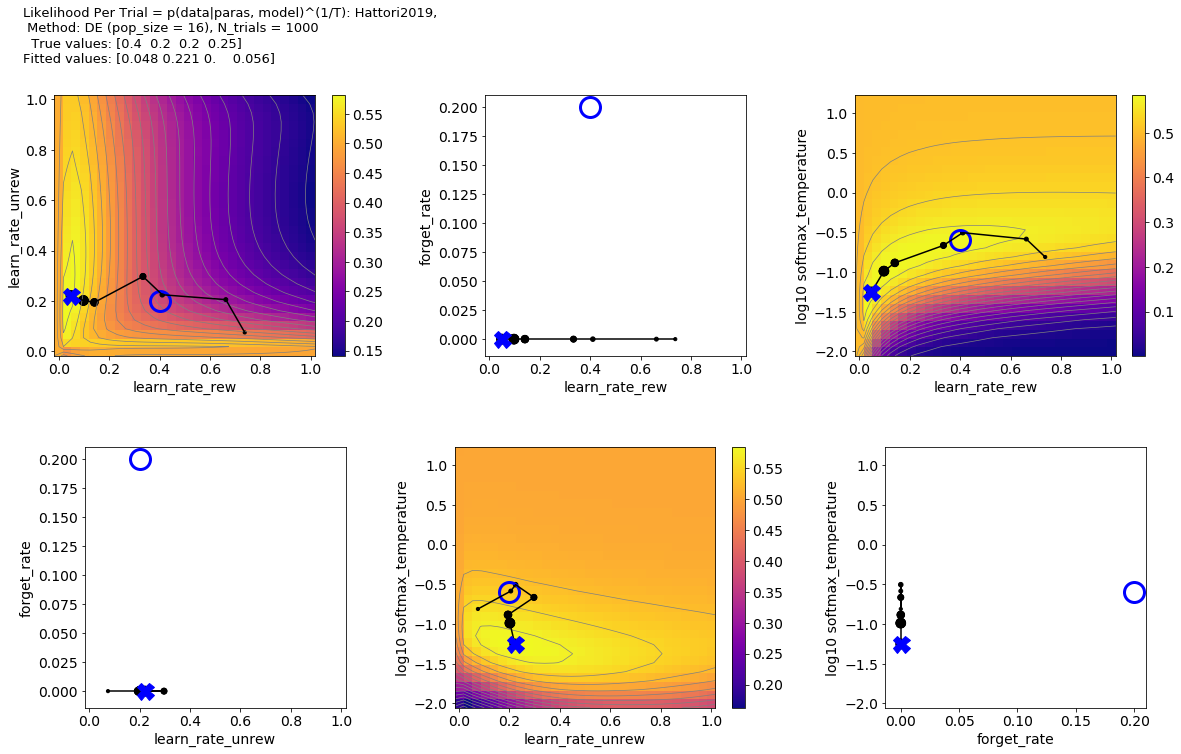

In [5]:
n_trials = 1000

forager = 'Hattori2019'
para_names = ['learn_rate_rew','learn_rate_unrew', 'forget_rate','softmax_temperature']
para_scales = ['linear','linear','linear', 'log']
para_bounds = [[0, 0, 0, 1e-2],
               [1, 1, 0, 15]]

# -- LL_surface --
compute_LL_surface(forager, para_names, para_bounds, 
                    true_para = [0.4, 0.2, 0.2, 0.25],  # Almost Hattori et al.
                    para_2ds = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]], # LL surfaces for user-defined pairs of paras
                    n_grids = [[30,30]] * 6, 
                    para_scales = para_scales,
                    n_trials = n_trials,
                    fit_method = 'DE', n_x0s = 8, pool = pool)


Here is the correct model.

Fitting using DE (pop_size = 16), pool = True...
  True para: [0.4  0.2  0.2  0.25]
Fitted para: [0.284 0.216 0.256 0.213]
km = 4, AIC = 980.215, BIC = 999.846
      LPT_AIC = 0.613, LPT_BIC = 0.607


LL_surface pair #5: 100%|███████████████████████████████████████████████████████████| 900/900 [00:02<00:00, 305.28it/s]


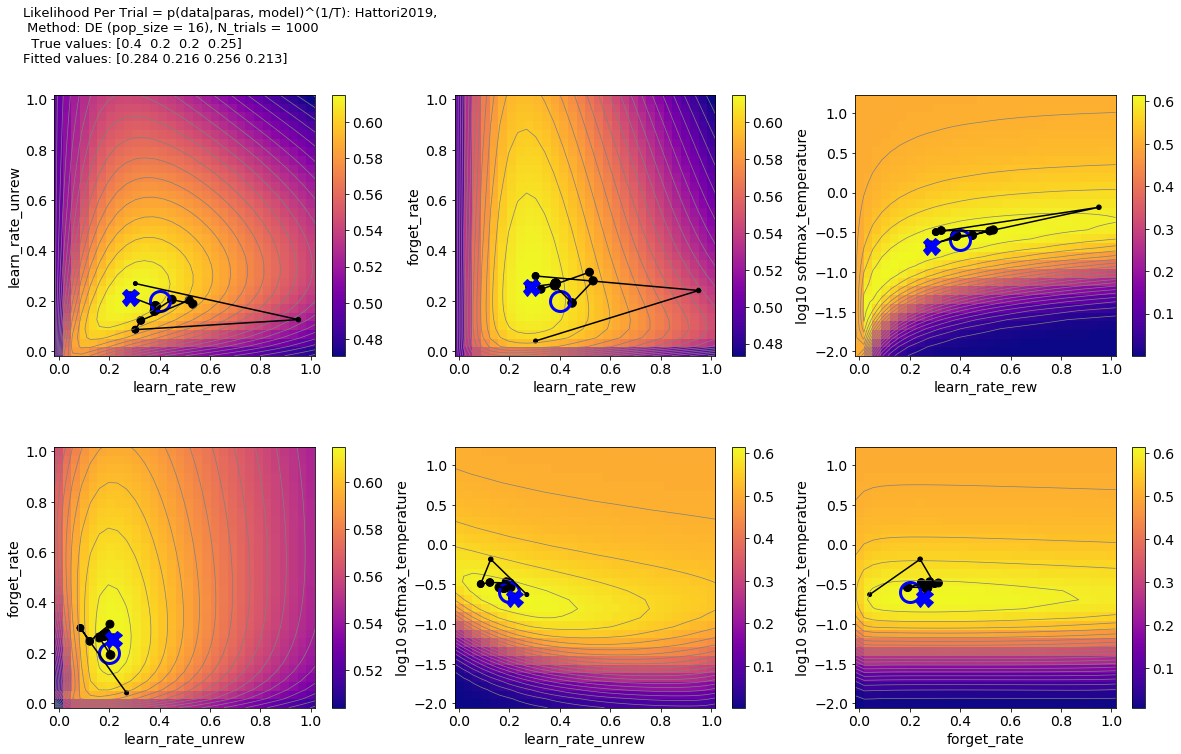

In [6]:
n_trials = 1000

forager = 'Hattori2019'
para_names = ['learn_rate_rew','learn_rate_unrew', 'forget_rate','softmax_temperature']
para_scales = ['linear','linear','linear', 'log']
para_bounds = [[0, 0, 0, 1e-2],
               [1, 1, 1, 15]]

# -- LL_surface --
compute_LL_surface(forager, para_names, para_bounds, 
                    true_para = [0.4, 0.2, 0.2, 0.25],  # Almost Hattori et al.
                    para_2ds = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]], # LL surfaces for user-defined pairs of paras
                    n_grids = [[30,30]] * 6, 
                    para_scales = para_scales,
                    n_trials = n_trials,
                    fit_method = 'DE', n_x0s = 8, pool = pool)


So this is a simple success model comparison:<br>
- Wrong model:   km = 3, AIC = 1170.69, BIC = 1185.41, LPT_AIC = 0.557, LPT_BIC = 0.553
- Correct model: km = 4, AIC = 1135.56, BIC = 1155.19, LPT_AIC = 0.588, LPT_BIC = 0.582<br>


We can thus compute the [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor), which is the relative likelihood of the wrong model (using AIC as an example. AIC has been suggested [to be better](https://en.wikipedia.org/wiki/Akaike_information_criterion#Comparisons_with_other_model_selection_methods)): <br>
\begin{equation}
Bayes\,factor = relative\,likelihood = \frac{p(data|model_i)}{p(data|best\, model)} = \frac{exp(E_{m,i})}{exp(E_{m,best})} = \frac{exp(-AIC_i/2)}{exp(-AIC_{min}/2)} = exp(-(AIC_i - AIC_{min})/2) = 1.77834e-08
\end{equation}

$E_m$ is the Bayesian model evidence. Drugowitsch et al. 2014 reports $log_{10}\sum_srelative\,likelihood_s$ in their Fig. 7, where `s` is their dataset.

Now we are ready for real model comparison!


---

Let's open another new notebook for model recovery!